# pythia-features

Compare Pythia prefetchers against:
- Different feature sets 
- Different baseline prefetchers

Can do comparisons across:
- [Benchmark suites](#plots-suites)
- [Single becnhmarks](#plots-single-benchmarks)


In [1]:
from importlib import reload

from matplotlib import cm
import numpy as np

from utils import plots, tables, utils
#%matplotlib widget

In [2]:
# Knobs
paths = {
    'degree1': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_features.csv', # Max pooling, degree 1
    'degree1_sum': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_features_sum.csv', # Sum pooling, degree 1, 3 tilings
    'degree1_flat': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat.csv',
    'degree1_flat_sum': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum.csv',
    'degree1_flat_sum_weighted': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_weighted.csv',
    'degree1_flat_sum_weighted_peraction': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_flat_sum_weighted_peraction.csv',
    'baseline': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_features.csv',
}

suites = [
    ('spec06', 'one_phase'),
    ('spec06', 'weighted'),
    ('gap', 'one_phase')
]
metrics  = [
    'ipc_improvement', 
    #'L2C_issued_prefetches', 
    'L2C_accuracy', 
    'L2C_coverage',
    #'L2C_mpki_reduction', 
]
single_features = [
    {'PC'},
    {'Offset'},
    {'Delta'},
    {'Address'},
    {'PC_Address'},
    {'Delta_Path'},
    {'PC_Delta'},
    {'Page'},
]
multi_features = [
    {'Delta_Path', 'PC_Delta'},
    {'Delta_Path', 'PC_Delta', 'Page'},
    {'Delta_Path', 'PC_Delta', 'Page', 'Offset'},
]
baselines = [
    'bo'
]
dpi = 100

# Plots (suites)
Fix prefetch degree to 1 for everything.

In [3]:
dfs = {
    'baseline': tables.load_stats_csv(paths['baseline'], baselines, prefetchers_level='l2'),
    'degree1': tables.load_stats_csv_pythia(paths['degree1'], single_features + multi_features),
    'degree1_sum': tables.load_stats_csv_pythia(paths['degree1_sum'], multi_features),
    'degree1_flat': tables.load_stats_csv_pythia(paths['degree1_flat'], multi_features),
    'degree1_flat_sum': tables.load_stats_csv_pythia(paths['degree1_flat_sum'], multi_features),
    'degree1_flat_sum_weighted': tables.load_stats_csv_pythia(paths['degree1_flat_sum_weighted'], multi_features),
    'degree1_flat_sum_weighted_peraction': tables.load_stats_csv_pythia(paths['degree1_flat_sum_weighted_peraction'], multi_features),
}

/u/cmolder/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Pythia features (max pooling)

*Note*: Max pooling = Sum pooling when only one feature is used.

=== spec06 one_phase ===


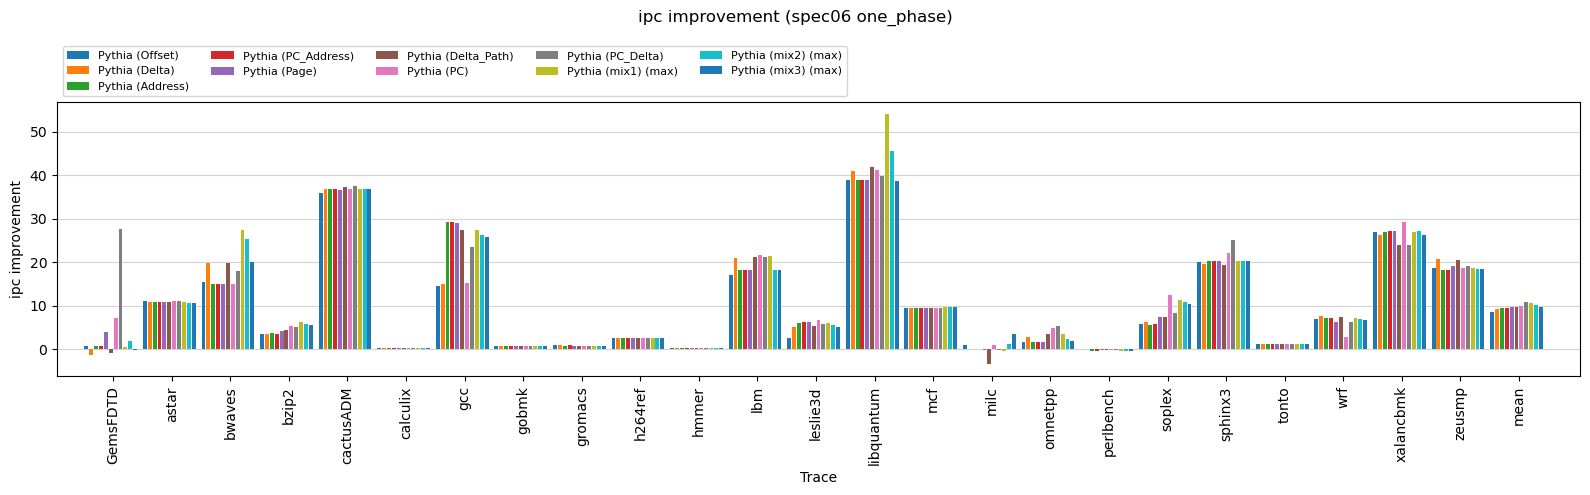

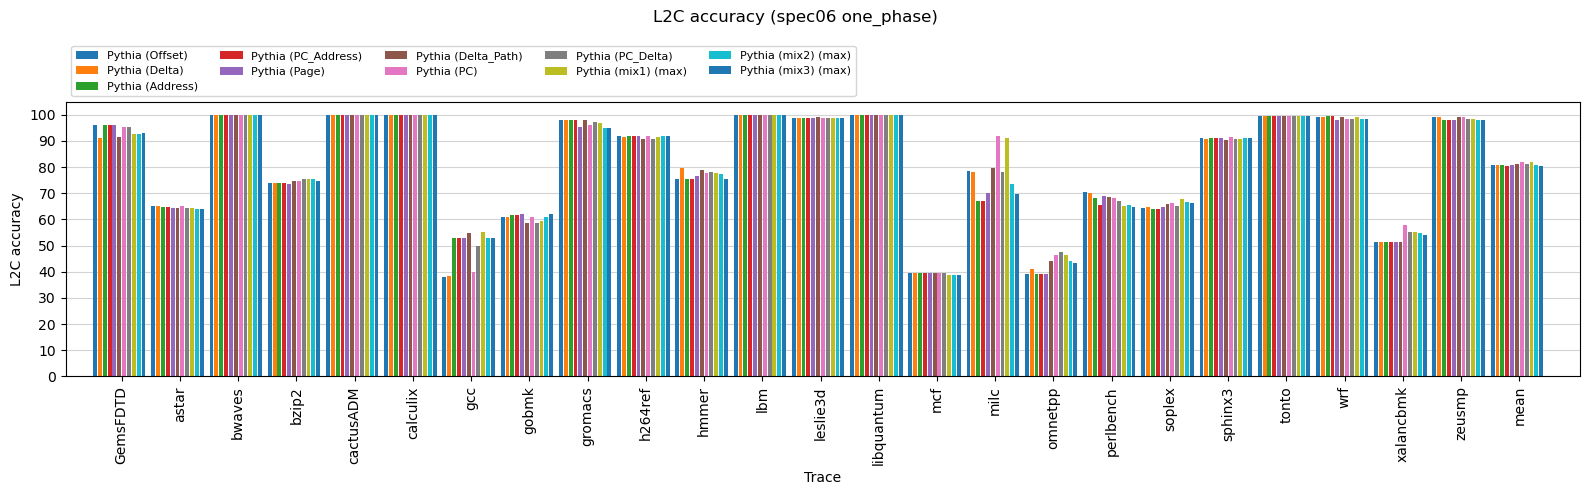

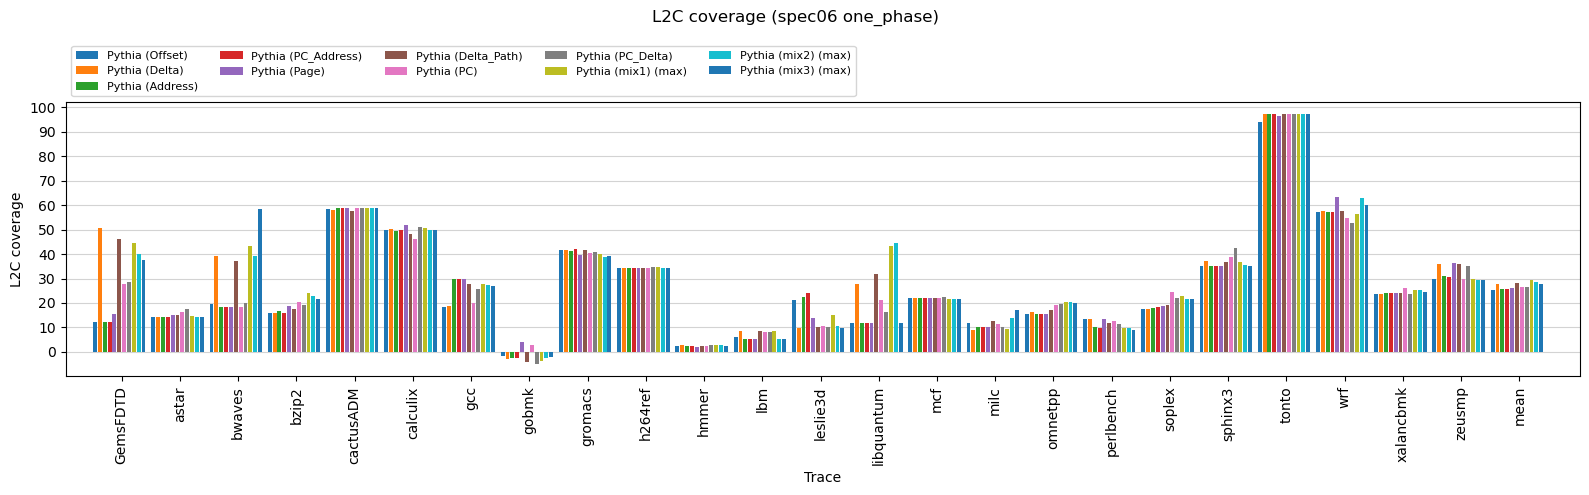

=== spec06 weighted ===


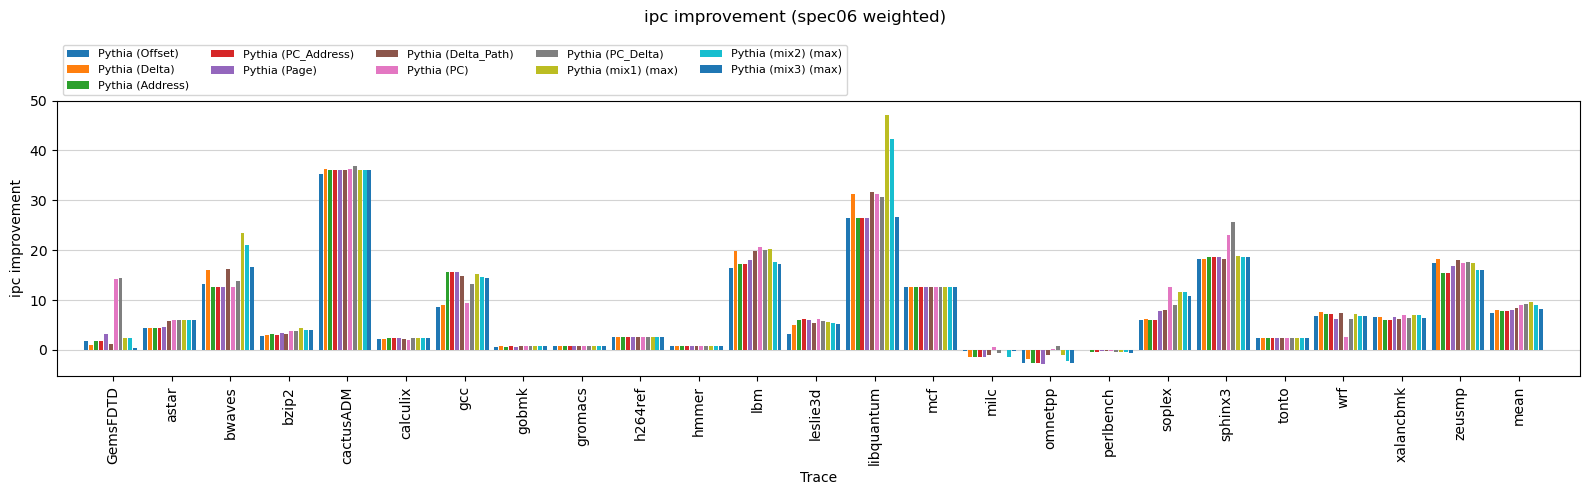

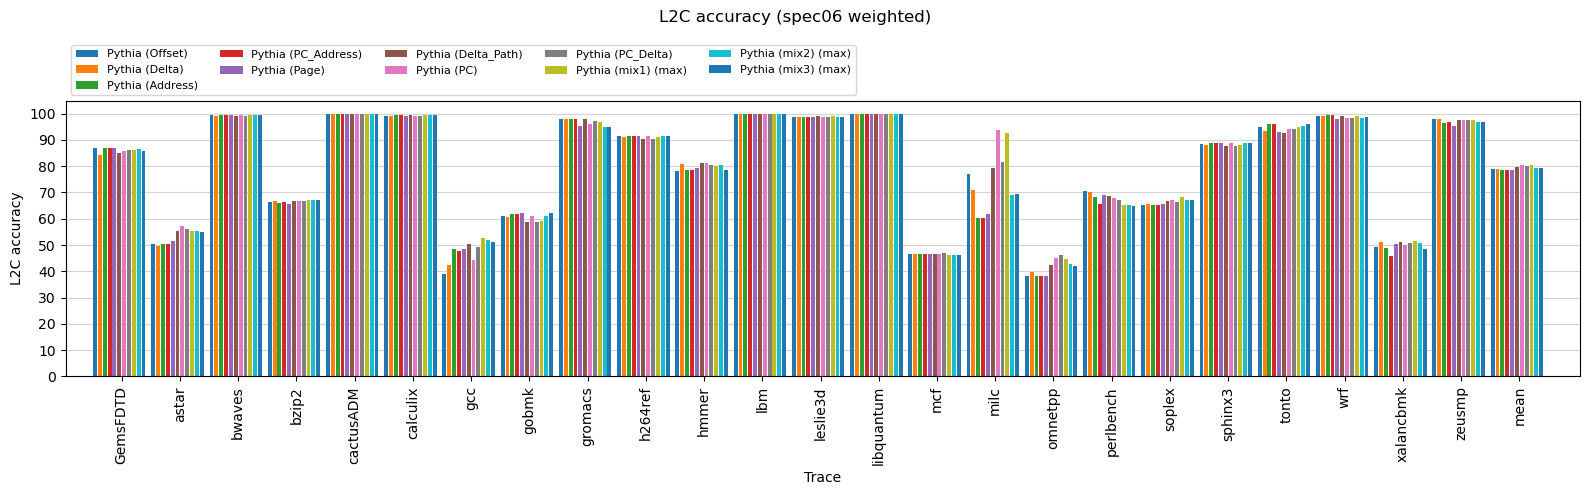

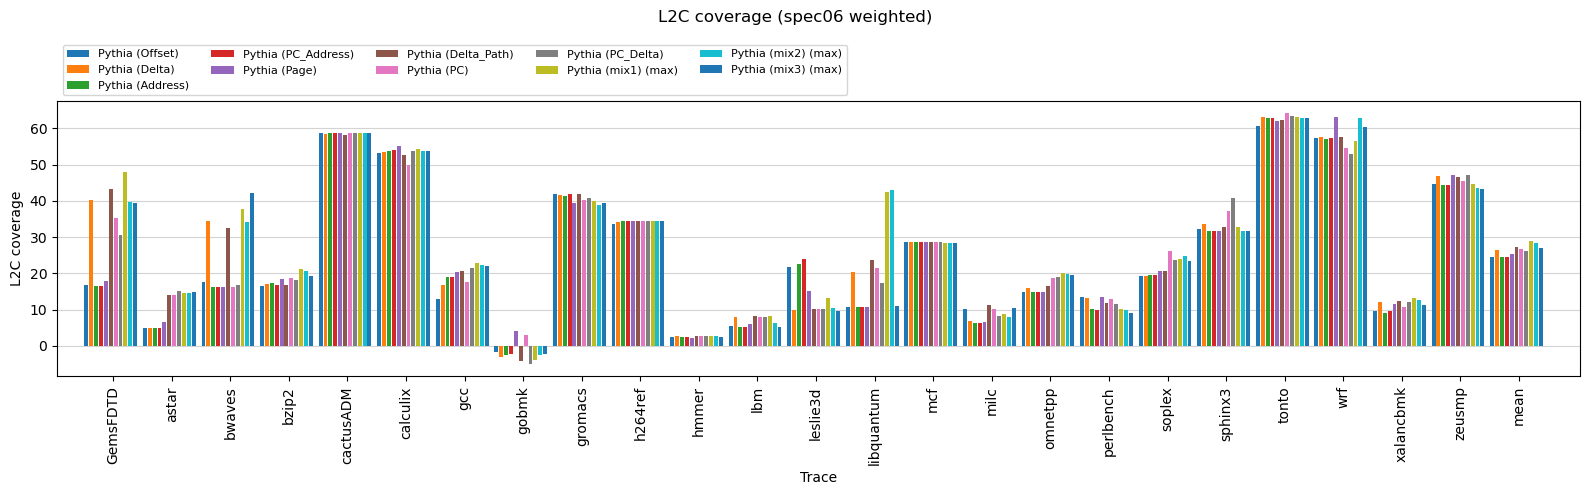

=== gap one_phase ===


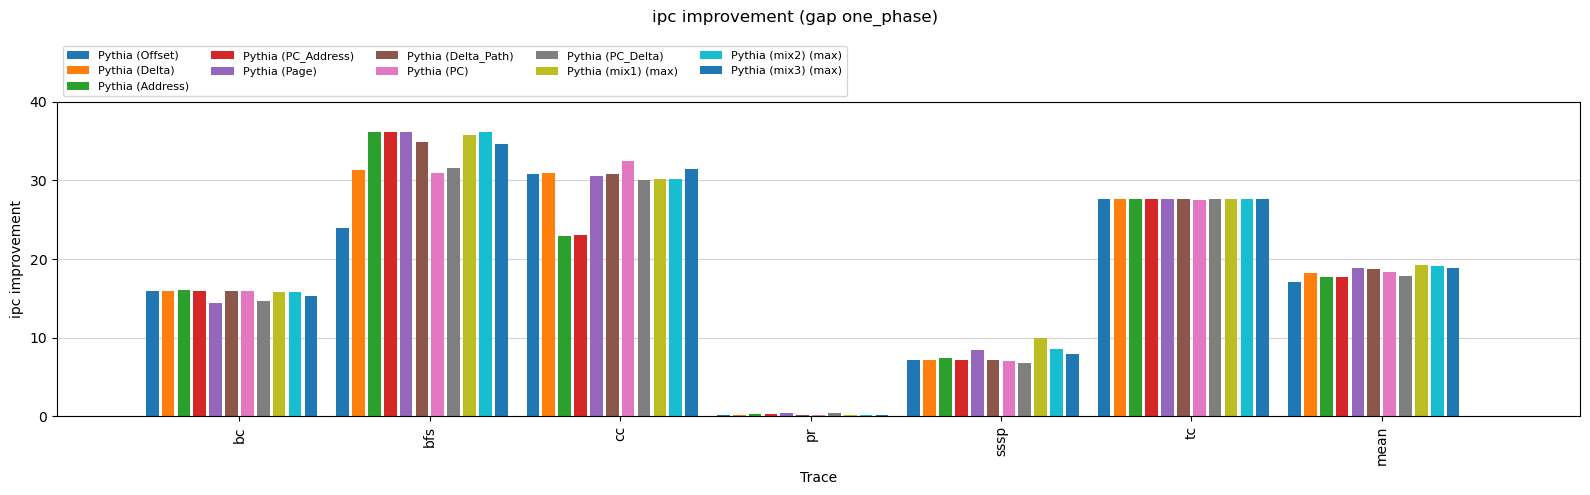

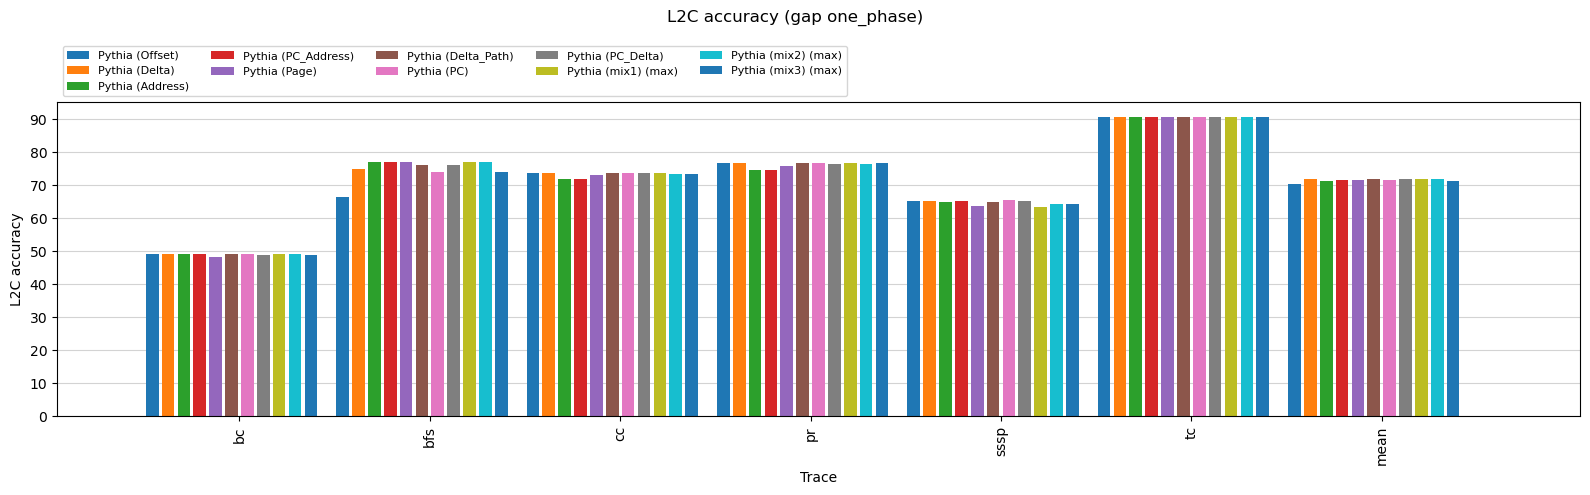

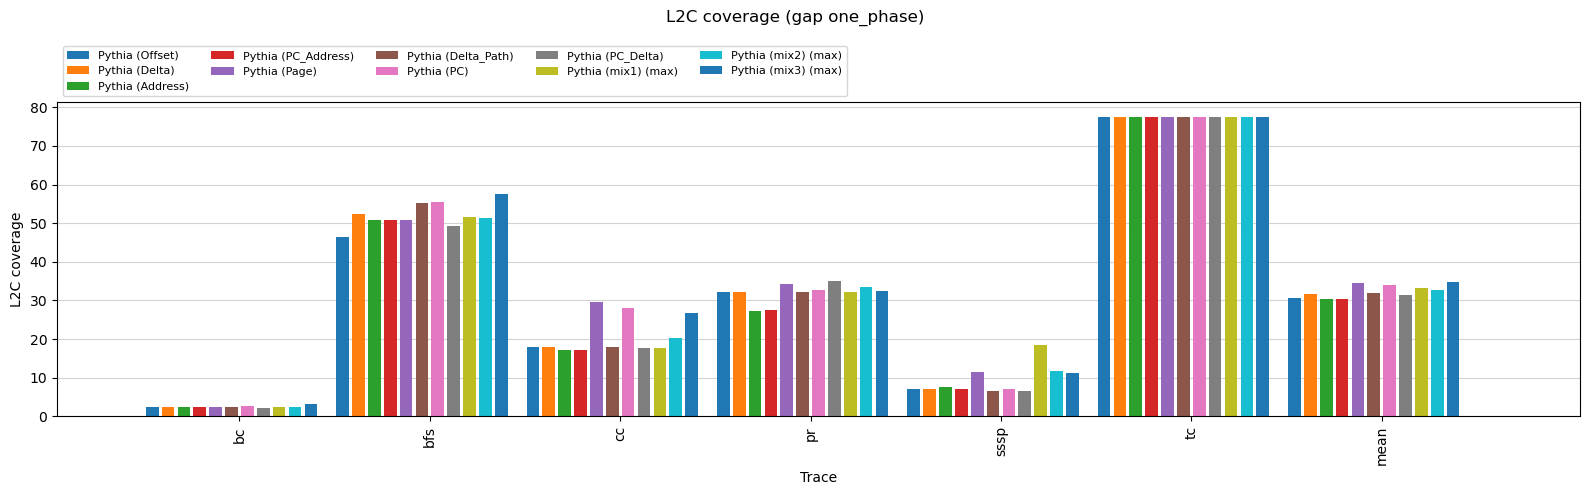

In [5]:
max_pool_df = {
    'Pythia (Offset)': dfs['degree1']['Offset'],
    'Pythia (Delta)': dfs['degree1']['Delta'],
    'Pythia (Address)': dfs['degree1']['Address'],
    'Pythia (PC_Address)': dfs['degree1']['PC_Address'],
    'Pythia (Page)': dfs['degree1']['Page'],
    'Pythia (Delta_Path)': dfs['degree1']['Delta_Path'],
    'Pythia (PC)': dfs['degree1']['PC'],
    'Pythia (PC_Delta)': dfs['degree1']['PC_Delta'],
    'Pythia (mix1) (max)': dfs['degree1']['Delta_Path, PC_Delta'],
    'Pythia (mix2) (max)': dfs['degree1']['Delta_Path, PC_Delta, Page'],
    'Pythia (mix3) (max)': dfs['degree1']['Delta_Path, Offset, PC_Delta, Page'],
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 5,
    'loc': 'lower left',
    'bbox_to_anchor': (0, 1),
}
plots.plot_everything(max_pool_df, suites=suites, metrics=metrics, 
                      legend_kwargs=legend_kwargs, dpi=dpi, figsize=(16,5))

## Pythia features (sum pooling)

=== spec06 one_phase ===


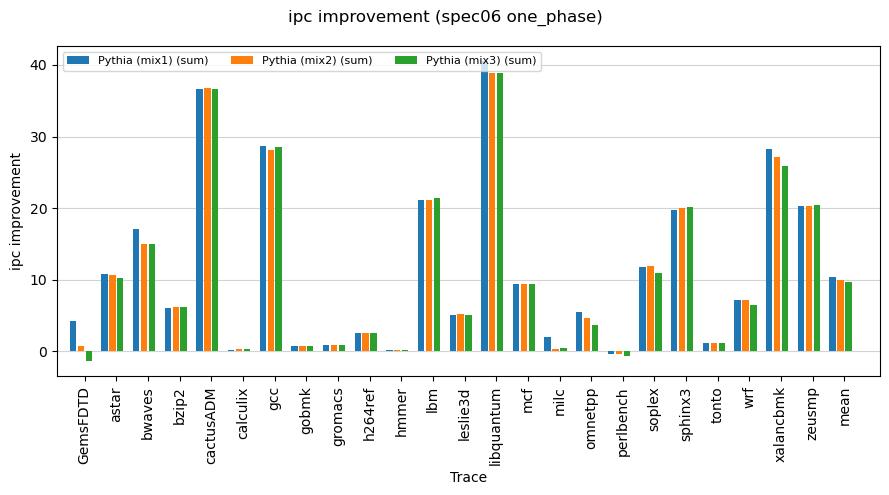

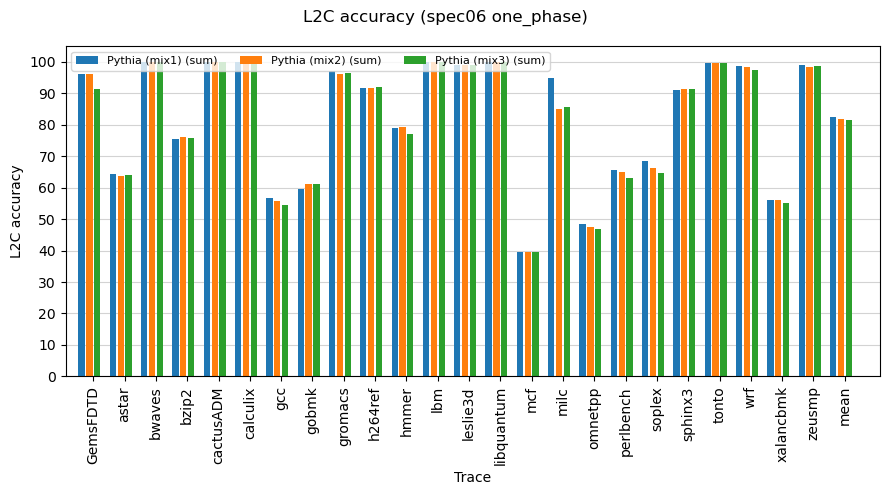

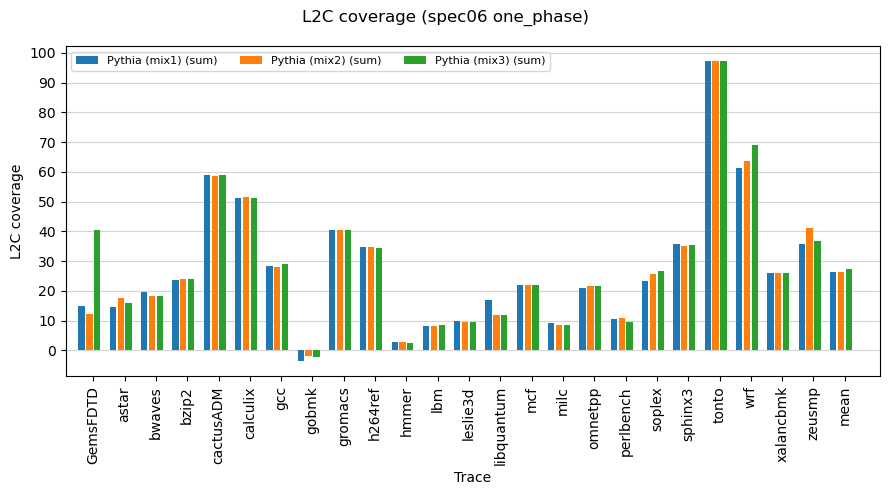

=== spec06 weighted ===


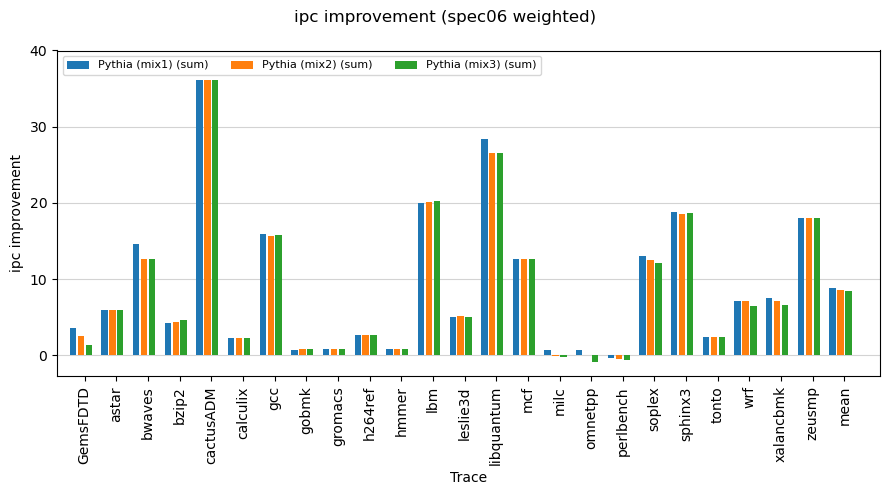

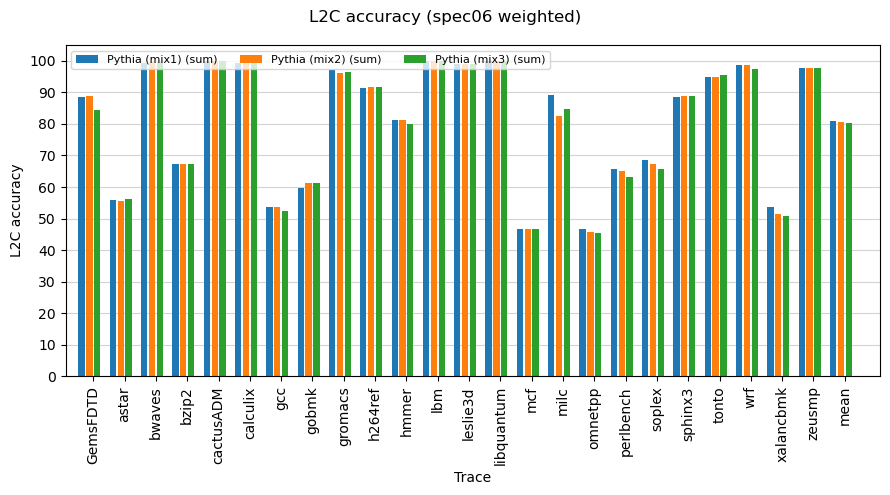

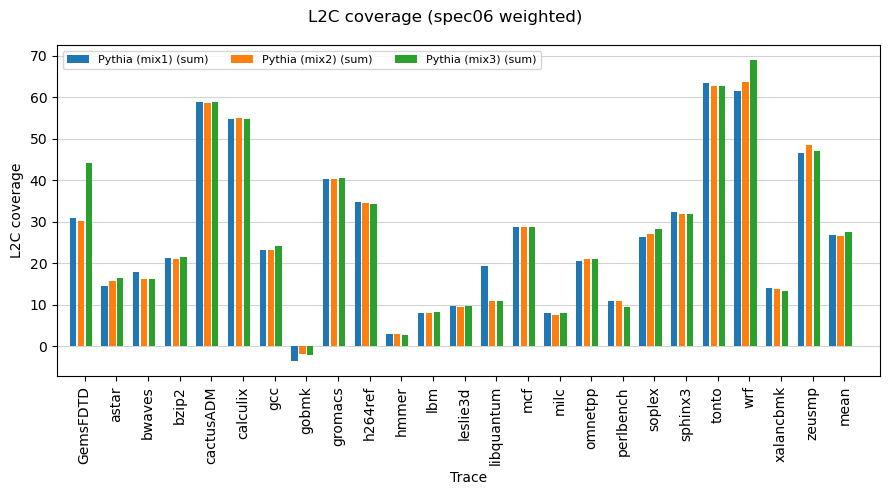

=== gap one_phase ===


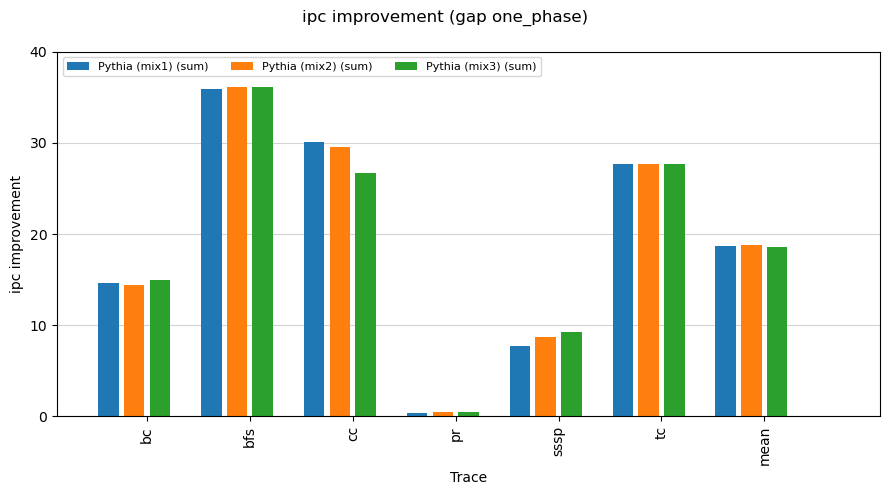

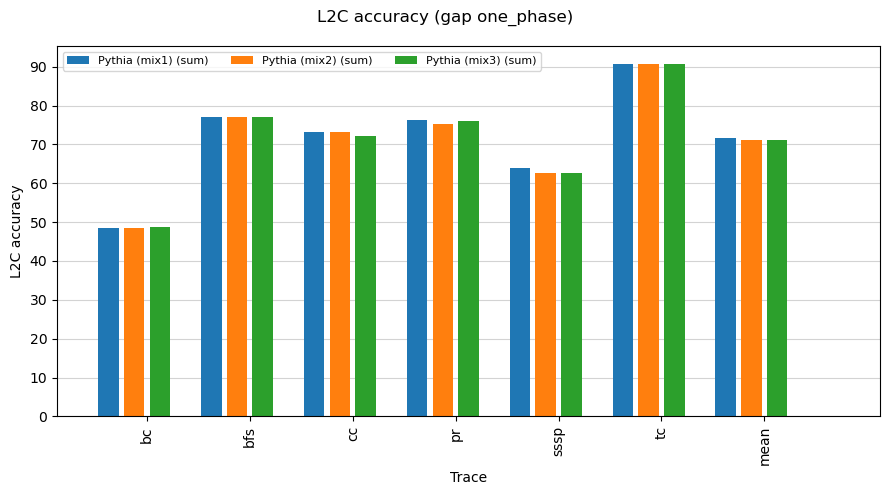

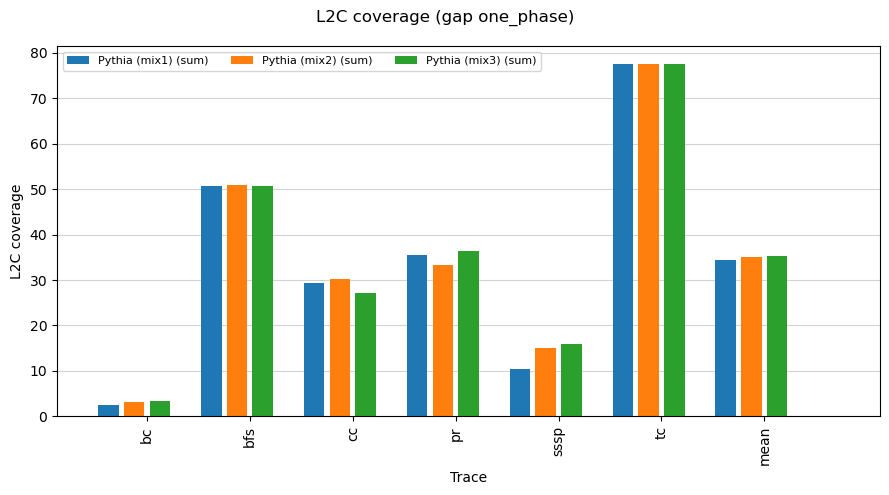

In [8]:
sum_pool_df = {
    'Pythia (mix1) (sum)': dfs['degree1_sum']['Delta_Path, PC_Delta'],
    'Pythia (mix2) (sum)': dfs['degree1_sum']['Delta_Path, PC_Delta, Page'],
    'Pythia (mix3) (sum)': dfs['degree1_sum']['Delta_Path, Offset, PC_Delta, Page'],
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 3,
    'loc': 'upper left',
    'bbox_to_anchor': (0, 1),
}
plots.plot_everything(sum_pool_df, suites=suites, metrics=metrics, 
                      legend_kwargs=legend_kwargs, dpi=dpi, figsize=(9,5))

## Pythia features (Various mixes vs. BO)

In [9]:
mix1_cmap = cm.get_cmap('Blues')
mix2_cmap = cm.get_cmap('Oranges')
mix3_cmap = cm.get_cmap('Greens')
c_max = 0.15
c_sum = 0.30
c_flat_max = 0.45
c_flat_sum = 0.60
c_flat_wsum_global = 0.75
c_flat_wsum_action = 0.85

### mix1: Delta_Path, PC_Delta

=== spec06 one_phase ===


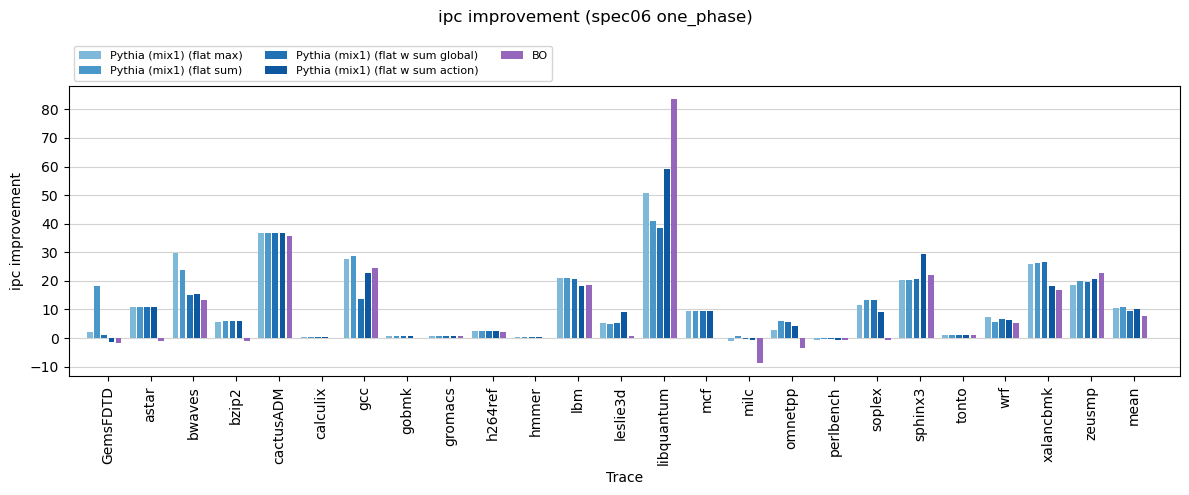

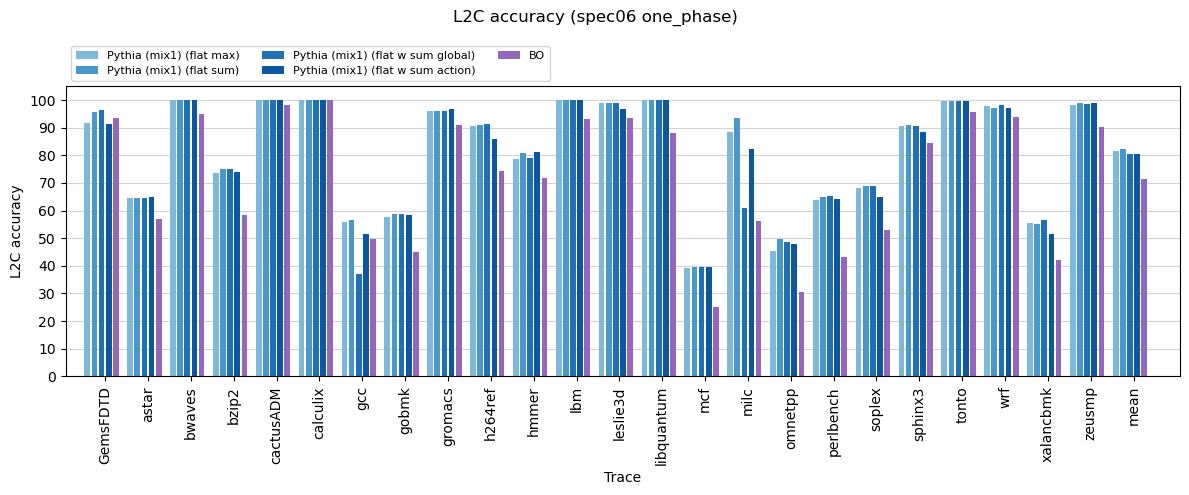

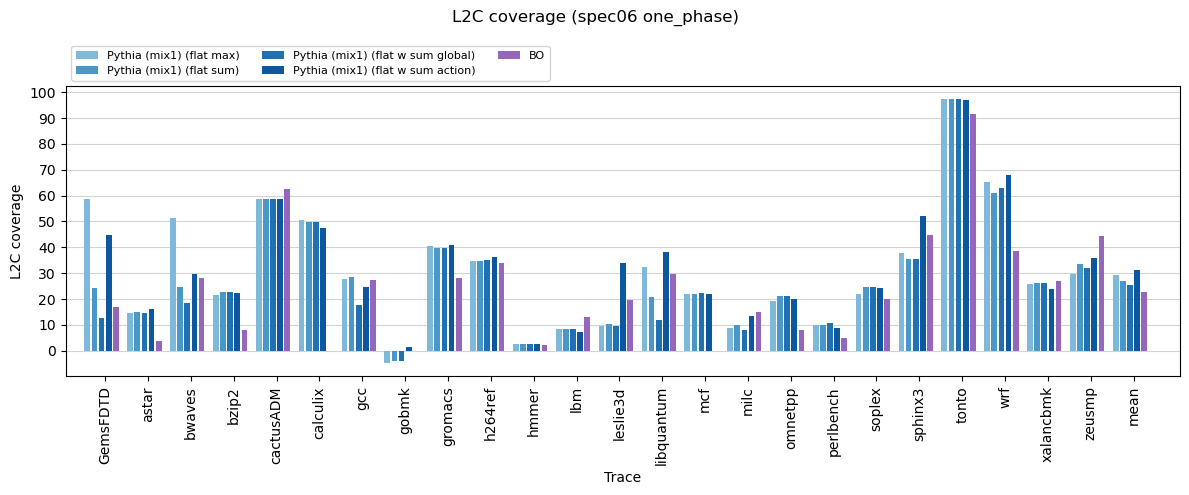

=== spec06 weighted ===


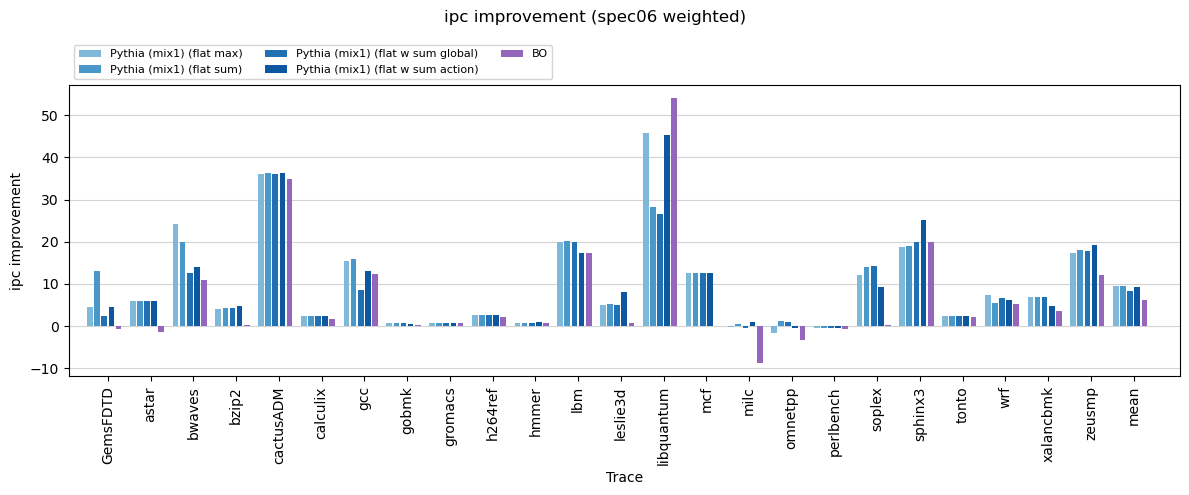

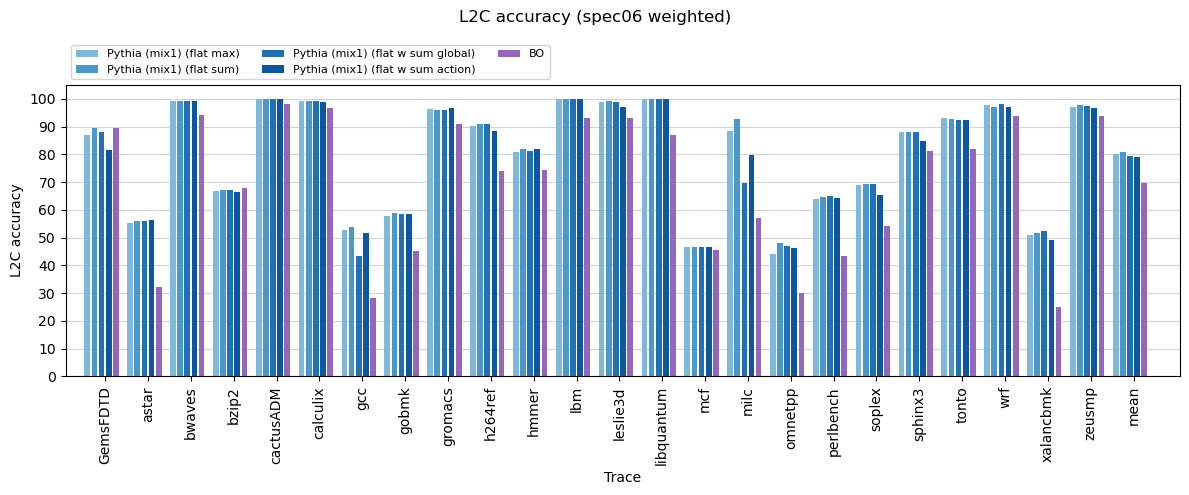

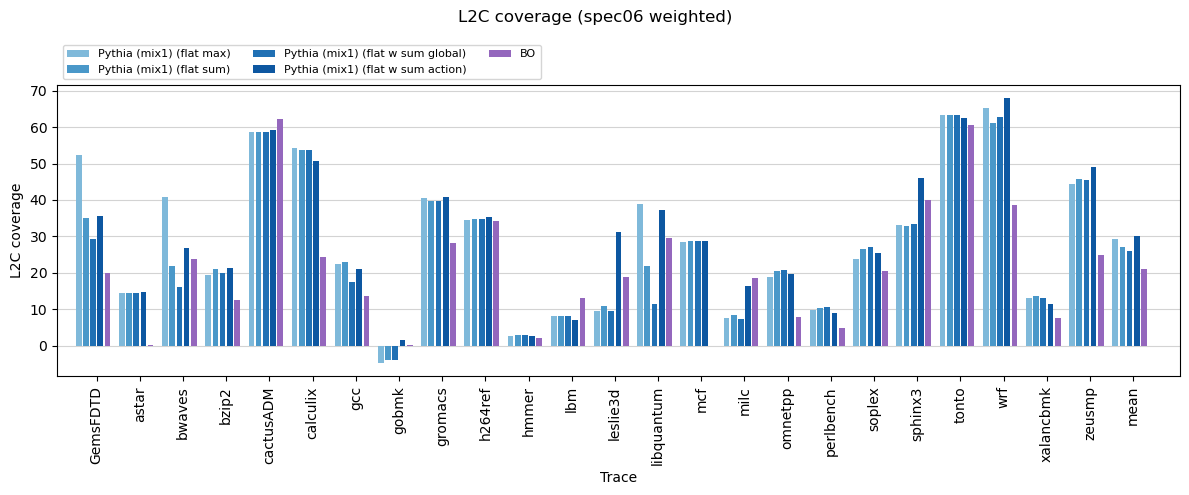

=== gap one_phase ===


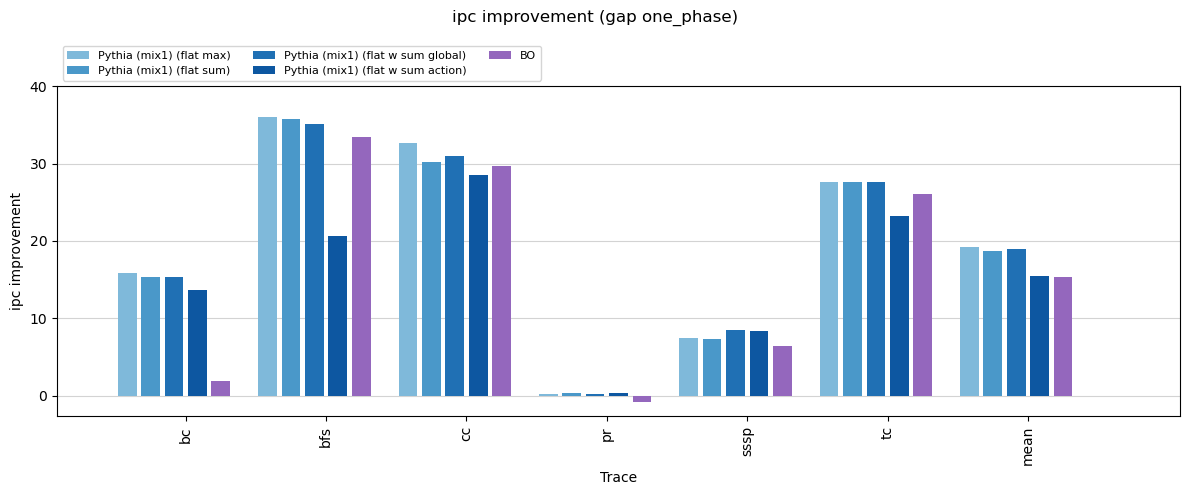

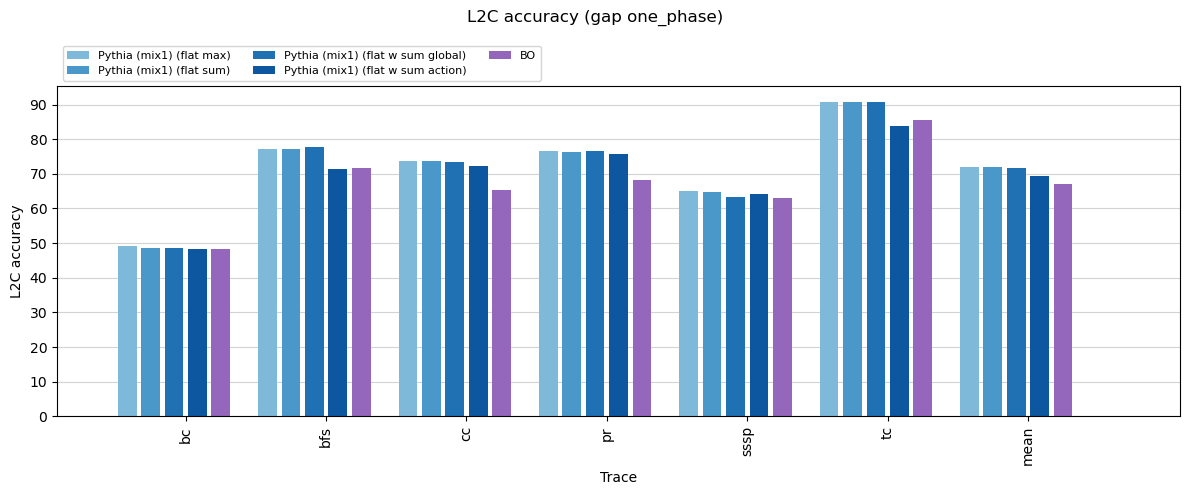

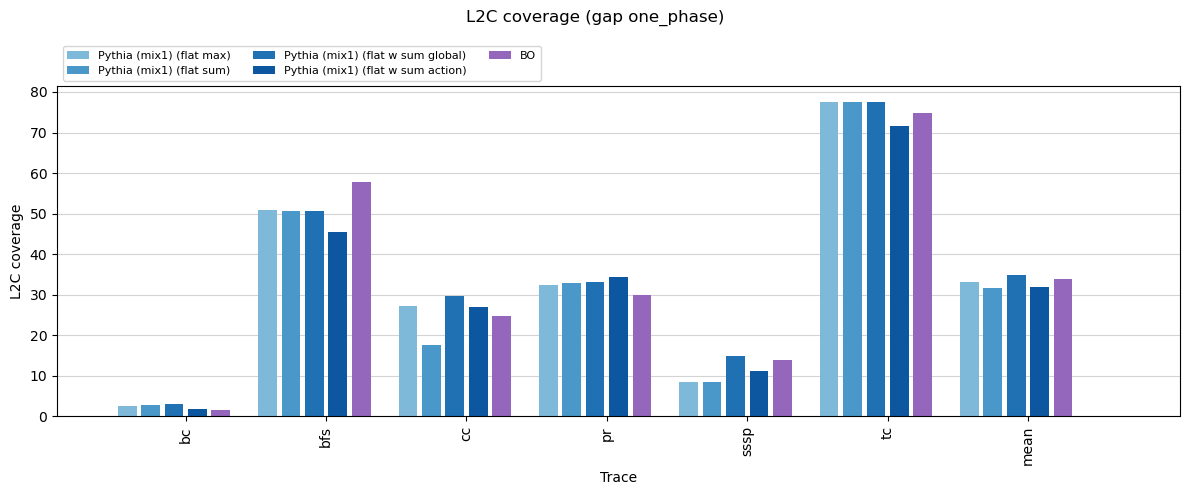

In [10]:
mix1_df = {
    #'Pythia (mix1) (max)': dfs['degree1']['Delta_Path, PC_Delta'],
    #'Pythia (mix1) (sum)': dfs['degree1_sum']['Delta_Path, PC_Delta'],
    'Pythia (mix1) (flat max)': dfs['degree1_flat']['Delta_Path, PC_Delta'],
    'Pythia (mix1) (flat sum)': dfs['degree1_flat_sum']['Delta_Path, PC_Delta'],
    'Pythia (mix1) (flat w sum global)': dfs['degree1_flat_sum_weighted']['Delta_Path, PC_Delta'],
    'Pythia (mix1) (flat w sum action)': dfs['degree1_flat_sum_weighted_peraction']['Delta_Path, PC_Delta'],
    'BO': dfs['baseline']['bo']
}
mix1_df_colors = {
    'Pythia (mix1) (max)': mix1_cmap(c_max),
    'Pythia (mix1) (sum)': mix1_cmap(c_sum),
    'Pythia (mix1) (flat max)': mix1_cmap(c_flat_max),
    'Pythia (mix1) (flat sum)': mix1_cmap(c_flat_sum),
    'Pythia (mix1) (flat w sum global)': mix1_cmap(c_flat_wsum_global),
    'Pythia (mix1) (flat w sum action)': mix1_cmap(c_flat_wsum_action),
    'BO': 'C4'
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 3,
    'loc': 'lower left',
    'bbox_to_anchor': (0, 1),
}
plots.plot_everything(mix1_df, suites=suites, metrics=metrics, 
                      colors=mix1_df_colors, dpi=dpi,
                      legend_kwargs=legend_kwargs, figsize=(12,5))

### mix2: Delta_Path, PC_Delta, Page

=== spec06 one_phase ===


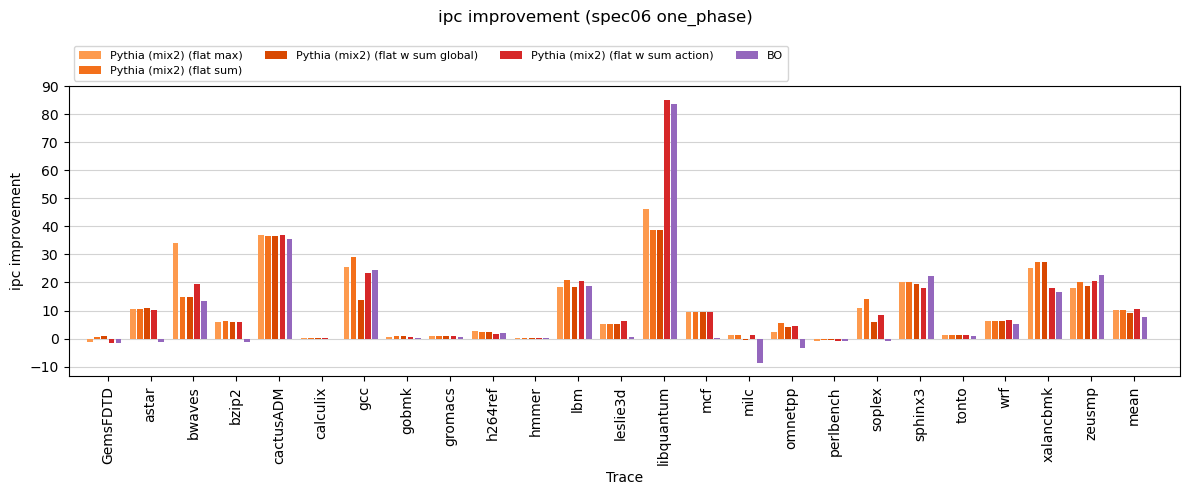

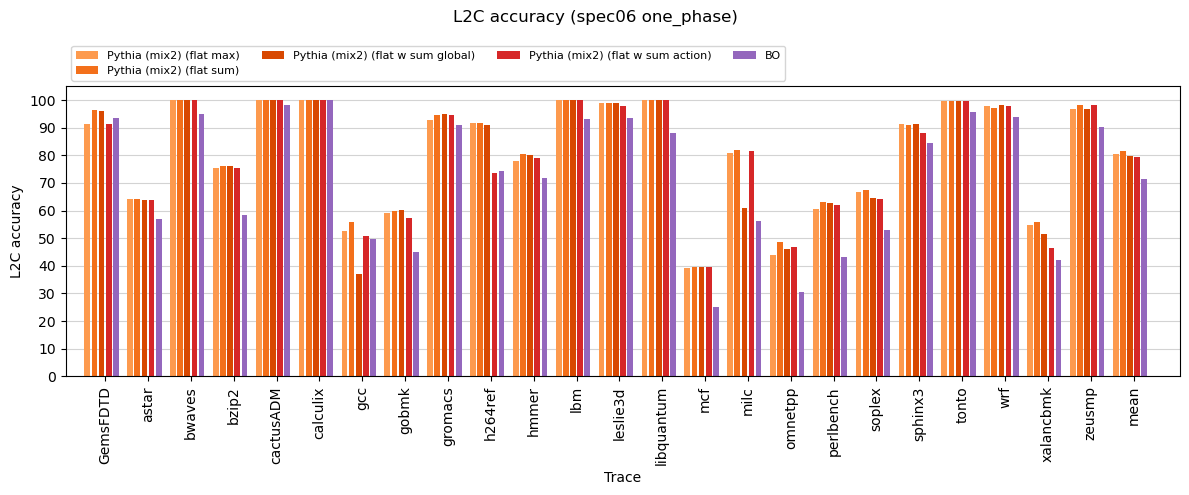

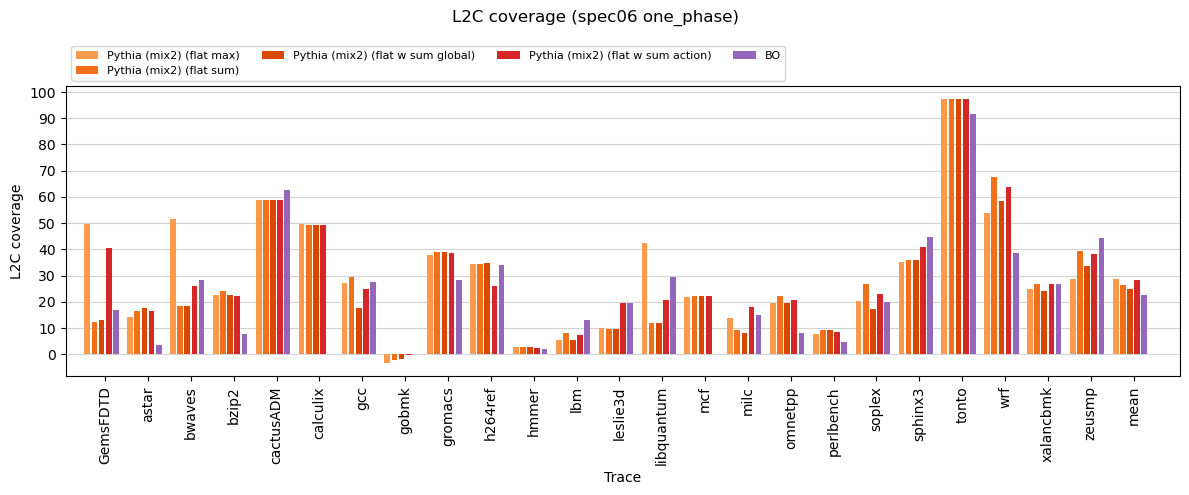

=== spec06 weighted ===


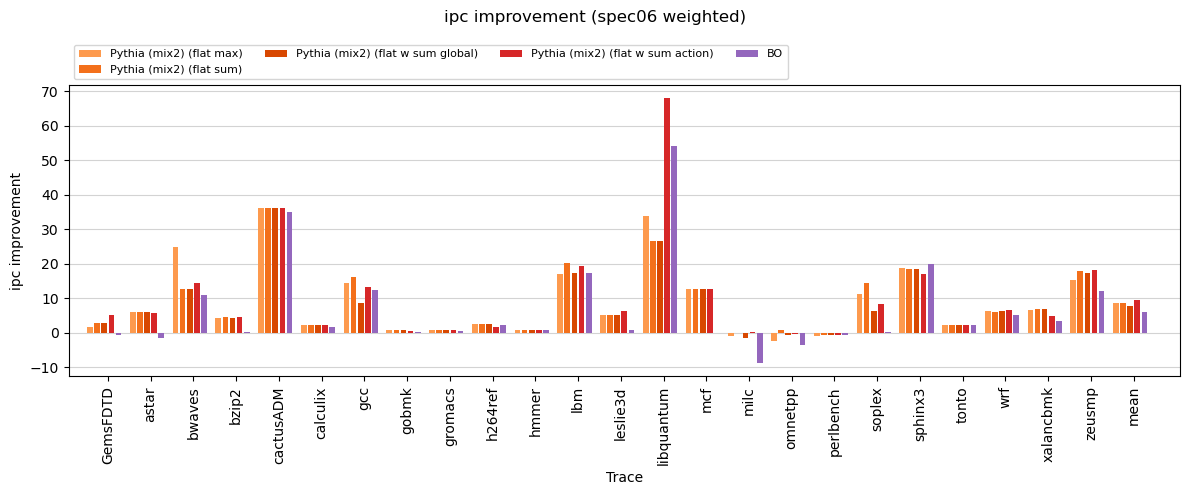

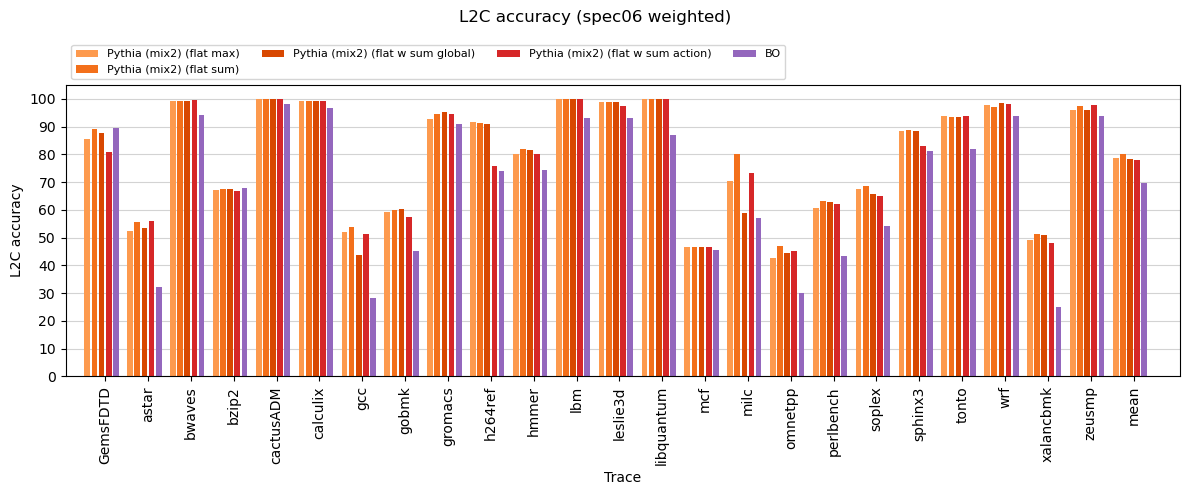

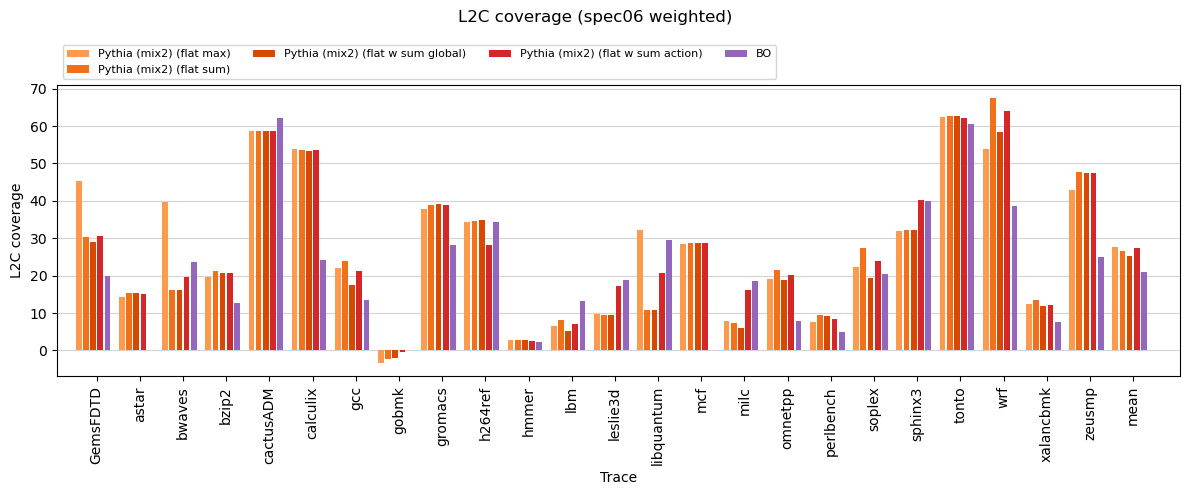

=== gap one_phase ===


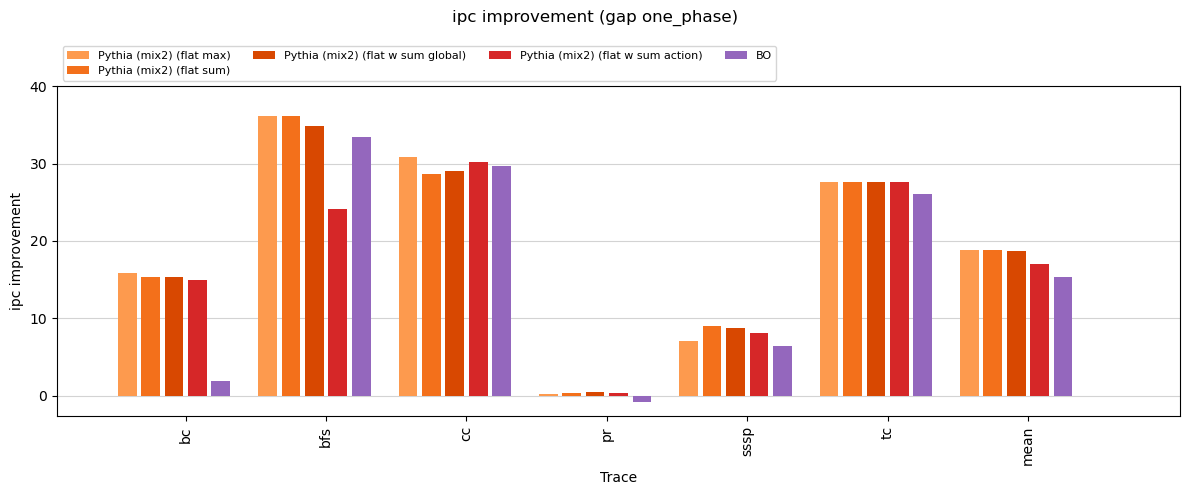

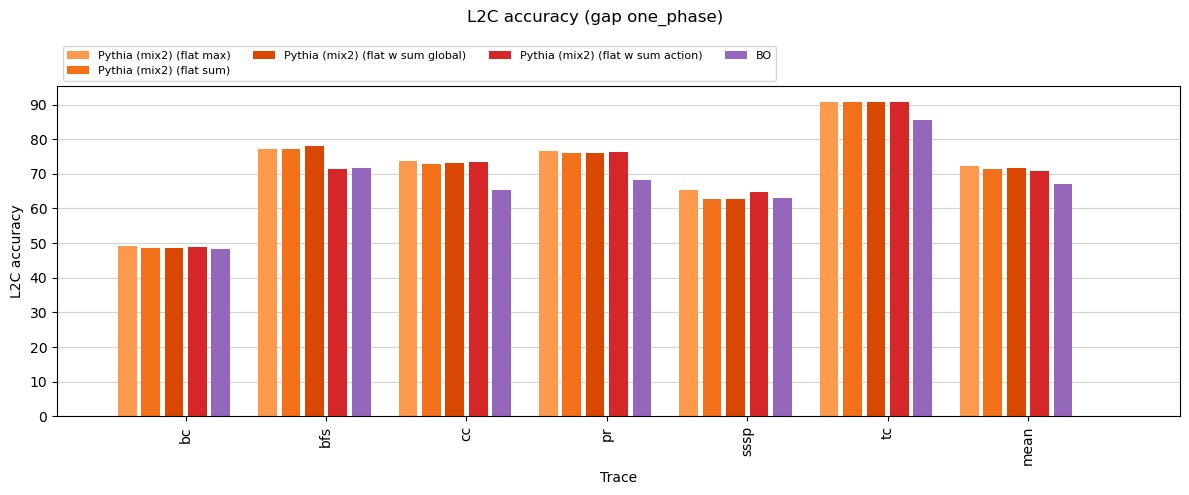

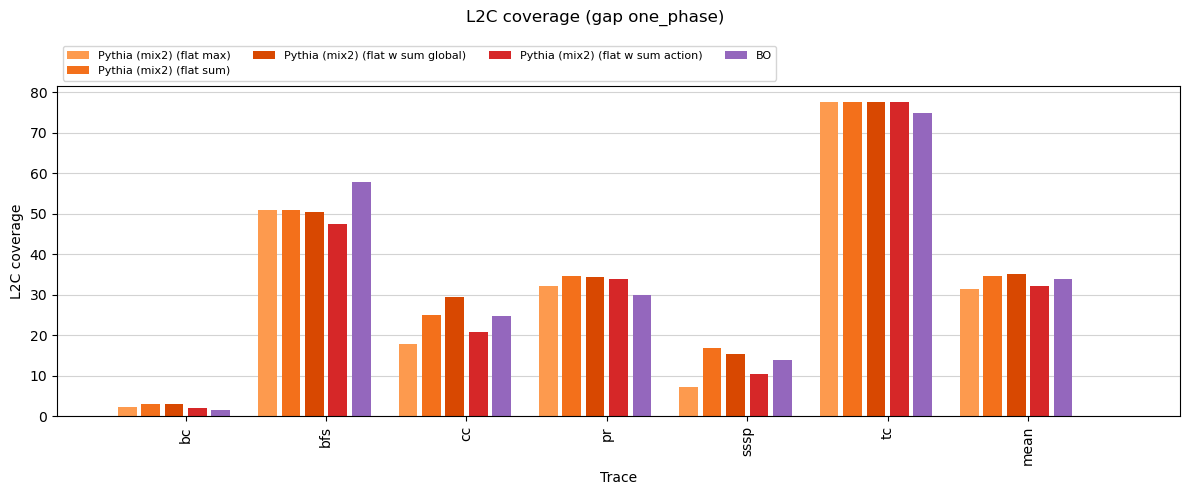

In [11]:
mix2_df = {
    #'Pythia (mix2) (max)': dfs['degree1']['Delta_Path, PC_Delta, Page'],
    #'Pythia (mix2) (sum)': dfs['degree1_sum']['Delta_Path, PC_Delta, Page'],
    'Pythia (mix2) (flat max)': dfs['degree1_flat']['Delta_Path, PC_Delta, Page'],
    'Pythia (mix2) (flat sum)': dfs['degree1_flat_sum']['Delta_Path, PC_Delta, Page'],
    'Pythia (mix2) (flat w sum global)': dfs['degree1_flat_sum_weighted']['Delta_Path, PC_Delta, Page'],
    'Pythia (mix2) (flat w sum action)': dfs['degree1_flat_sum_weighted_peraction']['Delta_Path, PC_Delta, Page'],
    'BO': dfs['baseline']['bo']
}
mix2_df_colors = {
    'Pythia (mix2) (max)': mix2_cmap(c_max),
    'Pythia (mix2) (sum)': mix2_cmap(c_sum),
    'Pythia (mix2) (flat max)': mix2_cmap(c_flat_max),
    'Pythia (mix2) (flat sum)': mix2_cmap(c_flat_sum),
    'Pythia (mix2) (flat w sum global)': mix2_cmap(c_flat_wsum_global),
    'Pythia (mix1) (flat w sum action)': mix2_cmap(c_flat_wsum_action),
    'BO': 'C4'
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 4,
    'loc': 'lower left',
    'bbox_to_anchor': (0, 1),
}
plots.plot_everything(mix2_df, suites=suites, metrics=metrics, 
                      colors=mix2_df_colors, dpi=dpi,
                      legend_kwargs=legend_kwargs, figsize=(12,5))

### mix3: Delta_Path, Offset, PC_Delta, Page

=== spec06 one_phase ===


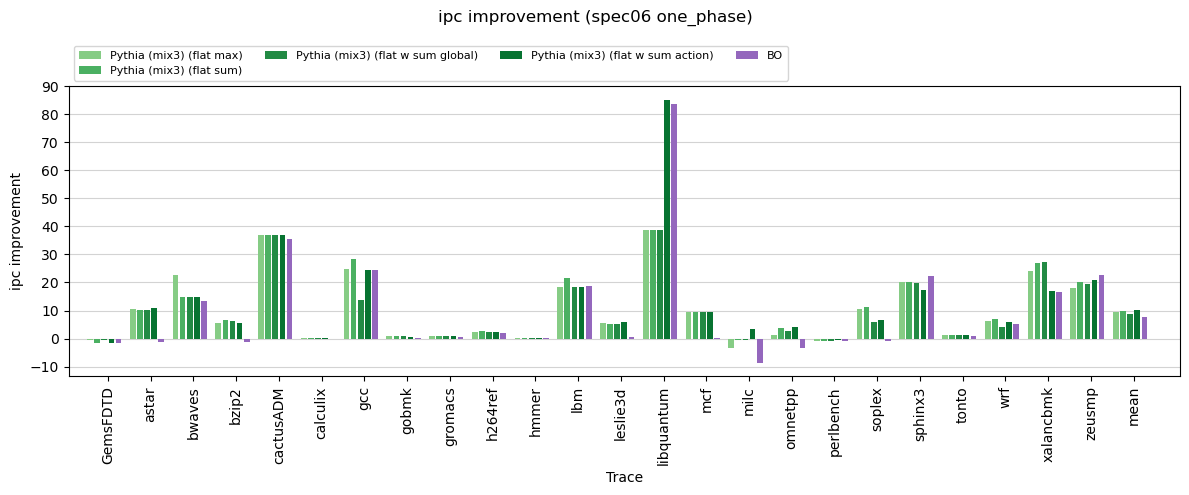

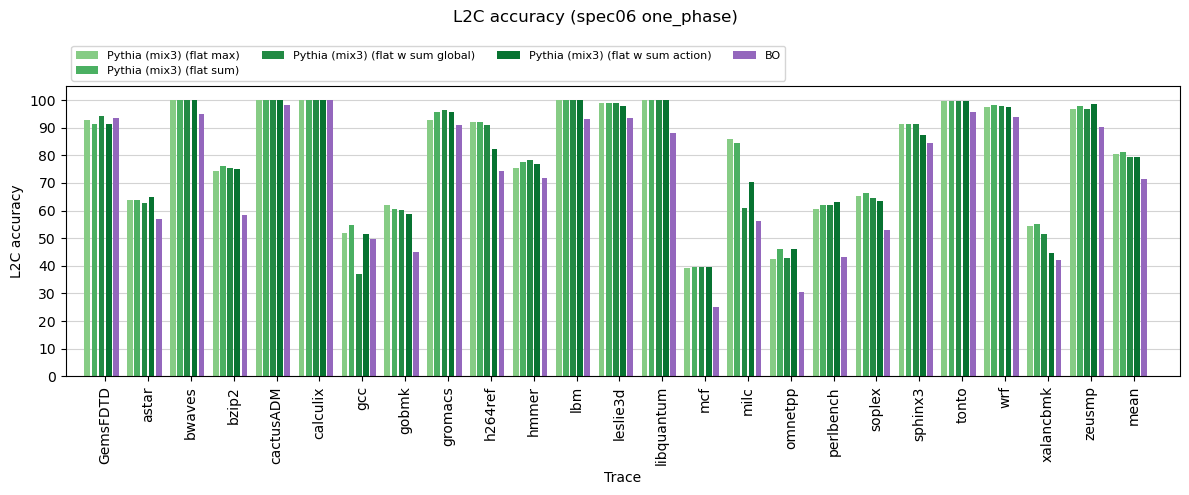

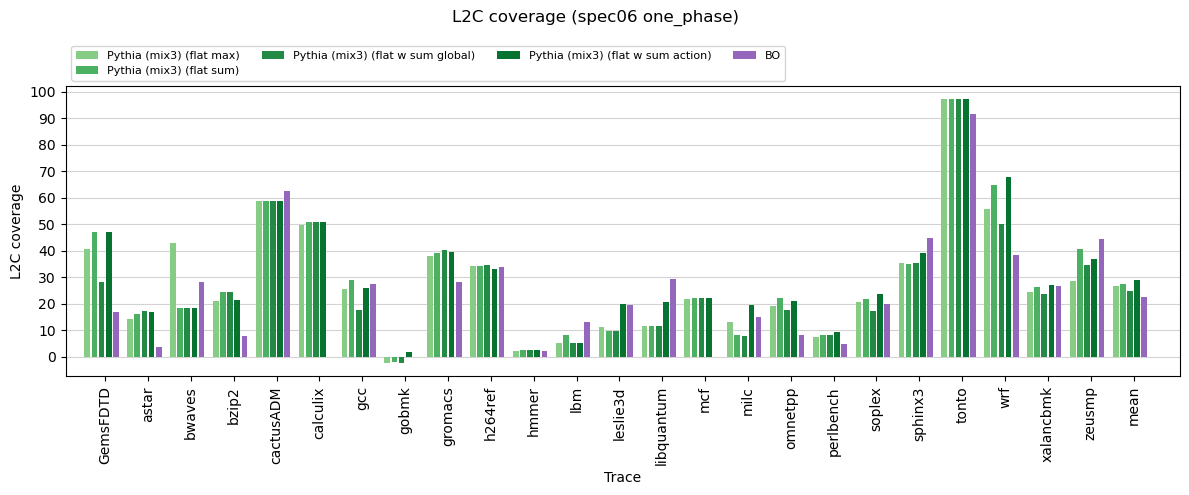

=== spec06 weighted ===


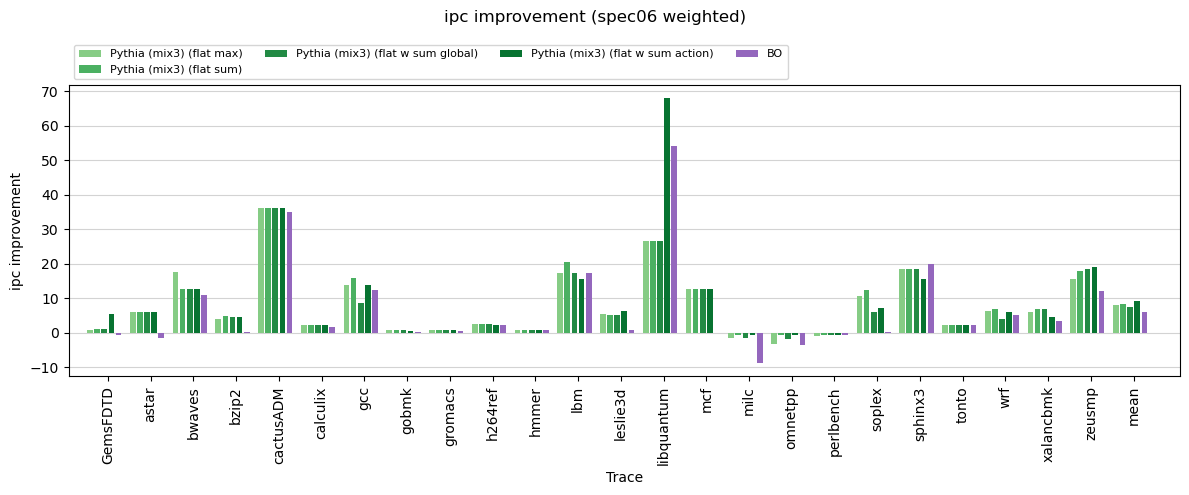

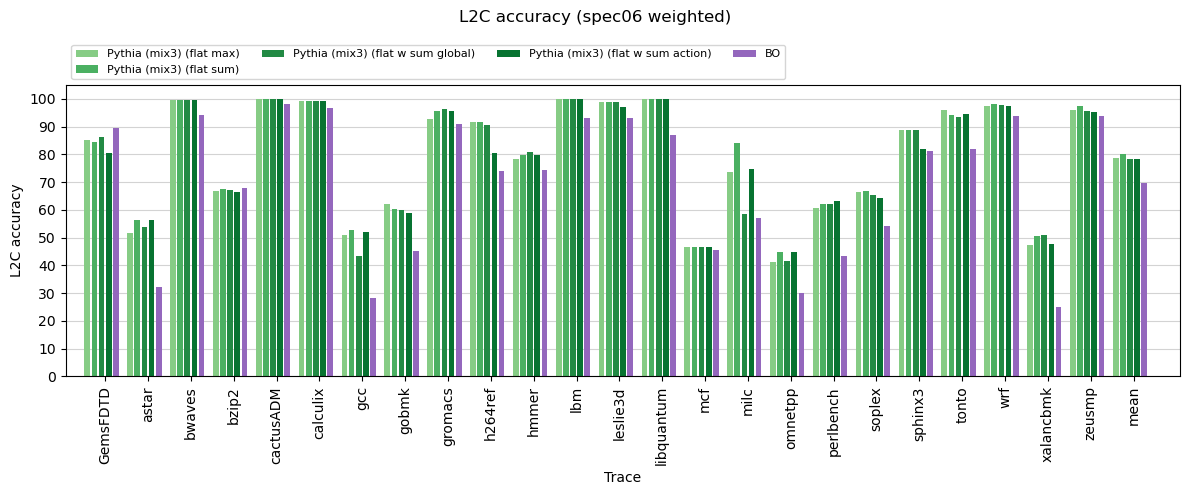

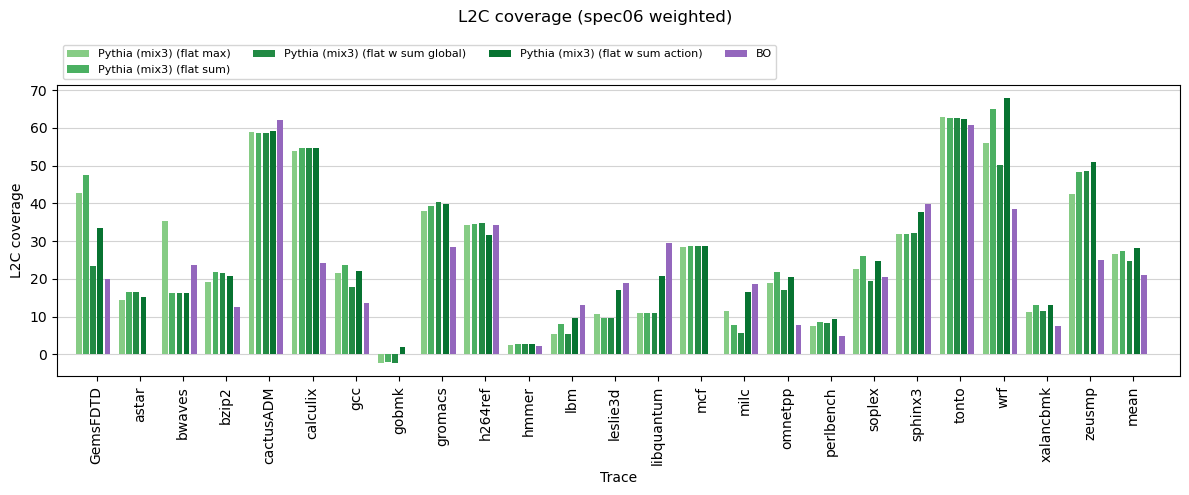

=== gap one_phase ===


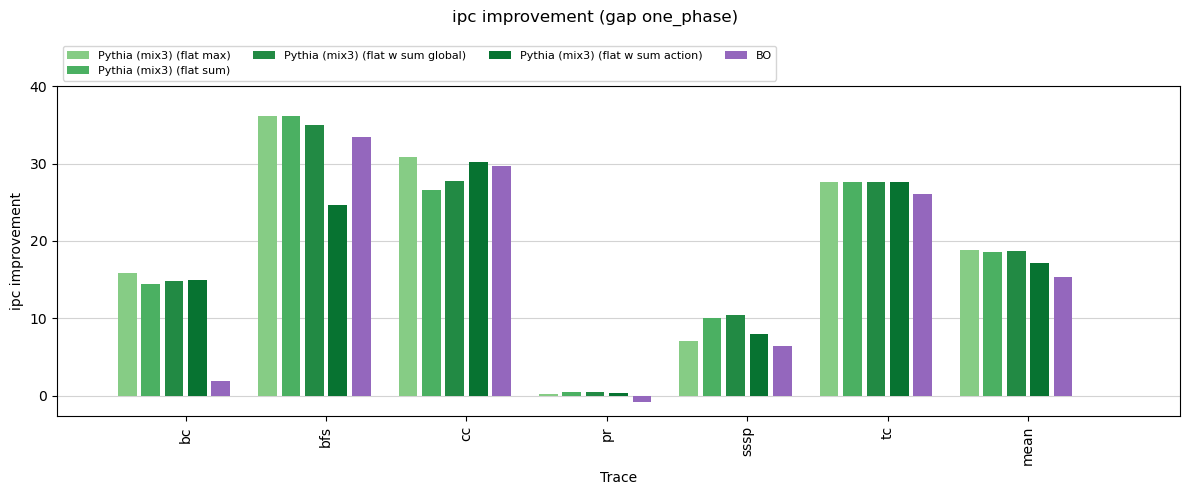

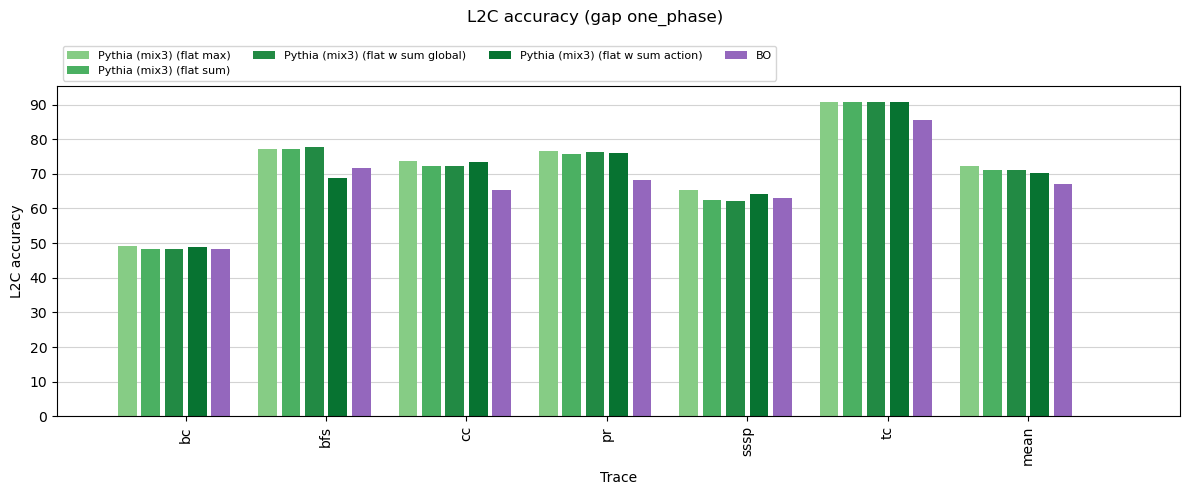

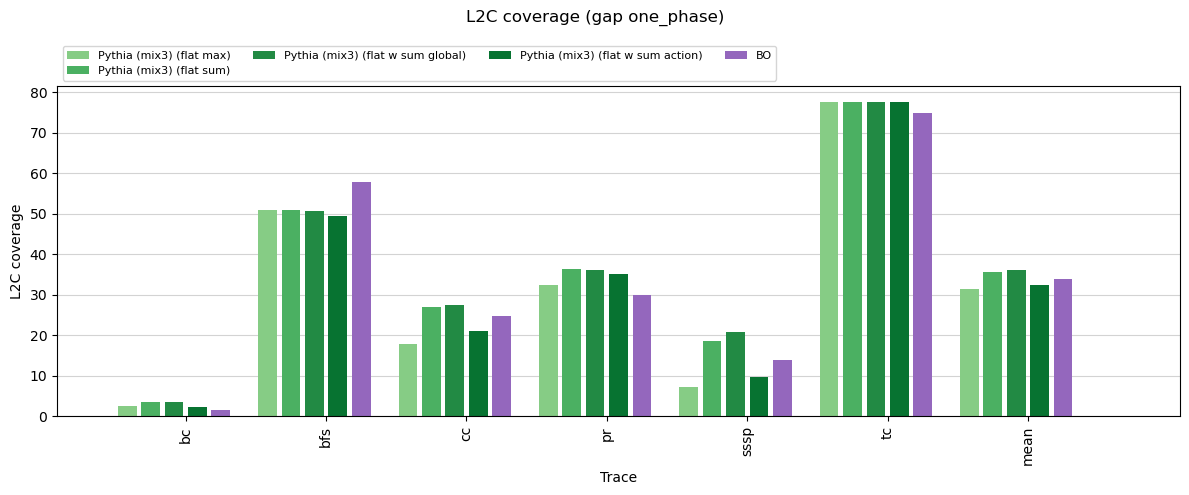

In [12]:
mix3_df = {
    # Mix 3
    #'Pythia (mix3) (max)': dfs['degree1']['Delta_Path, Offset, PC_Delta, Page'],
    #'Pythia (mix3) (sum)': dfs['degree1_sum']['Delta_Path, Offset, PC_Delta, Page'],
    'Pythia (mix3) (flat max)': dfs['degree1_flat']['Delta_Path, Offset, PC_Delta, Page'],
    'Pythia (mix3) (flat sum)': dfs['degree1_flat_sum']['Delta_Path, Offset, PC_Delta, Page'],
    'Pythia (mix3) (flat w sum global)': dfs['degree1_flat_sum_weighted']['Delta_Path, Offset, PC_Delta, Page'],
    'Pythia (mix3) (flat w sum action)': dfs['degree1_flat_sum_weighted_peraction']['Delta_Path, Offset, PC_Delta, Page'],
    # Best Offset
    'BO': dfs['baseline']['bo']
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 4,
    'loc': 'lower left',
    'bbox_to_anchor': (0, 1),
}
mix3_df_colors = {
    'Pythia (mix3) (max)': mix3_cmap(c_max),
    'Pythia (mix3) (sum)': mix3_cmap(c_sum),
    'Pythia (mix3) (flat max)': mix3_cmap(c_flat_max),
    'Pythia (mix3) (flat sum)': mix3_cmap(c_flat_sum),
    'Pythia (mix3) (flat w sum global)': mix3_cmap(c_flat_wsum_global),
    'Pythia (mix3) (flat w sum action)': mix3_cmap(c_flat_wsum_action),
    'BO': 'C4'
}
plots.plot_everything(mix3_df, suites=suites, metrics=metrics,
                      colors=mix3_df_colors, dpi=dpi,
                      legend_kwargs=legend_kwargs, figsize=(12,5))

# Tables

## Pythia features (max pooling)

In [13]:
tables.table_everything(max_pool_df, suites=suites, metrics=metrics)

=== spec06 one_phase ===
Pythia (Offset)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,0.692756,96.243694,12.324468
astar_313B,10.956044,65.032739,14.449829
bwaves_1861B,15.372055,99.998574,19.486202
bzip2_183B,3.471330,73.994424,16.085385
cactusADM_734B,35.965232,99.941513,58.565507
calculix_2670B,0.234843,100.000000,49.711538
gcc_13B,14.490611,38.043501,18.508826
gobmk_135B,0.681535,60.991819,-1.797690
gromacs_1B,0.819774,97.891445,41.765047


Pythia (Delta)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.316642,91.256537,50.731190
astar_313B,10.832843,64.969092,14.412823
bwaves_1861B,19.728705,99.993317,39.329275
bzip2_183B,3.393138,73.960658,16.067267
cactusADM_734B,36.819839,99.928881,57.916770
calculix_2670B,0.235190,100.000000,50.192308
gcc_13B,14.982898,38.509735,18.867803
gobmk_135B,0.755888,60.825087,-2.996517
gromacs_1B,0.820274,97.919888,41.735171


Pythia (Address)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,0.690956,96.243063,12.339750
astar_313B,10.864328,64.935779,14.444761
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,3.710930,73.825402,16.656953
cactusADM_734B,36.713149,99.946337,58.792491
calculix_2670B,0.234843,100.000000,49.615385
gcc_13B,29.187554,53.011679,29.933431
gobmk_135B,0.688447,61.735018,-2.455610
gromacs_1B,0.809783,97.840989,41.427356


Pythia (PC_Address)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,0.681953,96.243853,12.330458
astar_313B,10.912924,64.919840,14.438758
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,3.482808,73.913300,15.915986
cactusADM_734B,36.713149,99.946337,58.792491
calculix_2670B,0.233801,100.000000,49.855769
gcc_13B,29.171975,53.055767,29.954177
gobmk_135B,0.700281,61.698804,-2.343841
gromacs_1B,0.822272,97.904281,42.017636


Pythia (Page)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,3.949477,96.050216,15.481117
astar_313B,10.824629,64.535949,14.939768
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,4.132024,73.418793,18.697068
cactusADM_734B,36.675046,99.946423,58.840702
calculix_2670B,0.237970,99.921691,51.730769
gcc_13B,28.907830,52.864824,29.796216
gobmk_135B,0.664780,62.178992,4.179338
gromacs_1B,0.798793,95.382257,39.482690


Pythia (Delta_Path)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.012352,91.651413,46.074002
astar_313B,10.748655,64.385496,15.217644
bwaves_1861B,19.808710,99.997651,37.302394
bzip2_183B,4.329299,74.697464,17.577227
cactusADM_734B,37.281436,99.938129,57.809347
calculix_2670B,0.226505,100.000000,48.269231
gcc_13B,27.336804,54.650673,27.815566
gobmk_135B,0.704260,58.654805,-4.057634
gromacs_1B,0.819275,97.916886,41.762331


Pythia (PC)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,7.209348,95.333322,27.660701
astar_313B,10.993005,65.286771,16.357747
bwaves_1861B,14.937931,99.997279,18.363397
bzip2_183B,5.231745,74.580477,20.298690
cactusADM_734B,36.788268,99.945689,58.793342
calculix_2670B,0.206703,99.915966,46.057692
gcc_13B,15.261930,39.961102,19.922544
gobmk_135B,0.774529,60.927491,2.934699
gromacs_1B,0.795296,96.016081,40.334613


Pythia (PC_Delta)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,27.558562,95.249573,28.688152
astar_313B,11.048446,64.510734,17.709651
bwaves_1861B,17.858431,99.998639,20.101614
bzip2_183B,4.997166,75.302934,19.259800
cactusADM_734B,37.420786,99.945828,58.775590
calculix_2670B,0.234843,99.922300,51.105769
gcc_13B,23.491982,49.929934,25.847704
gobmk_135B,0.731278,58.578735,-4.917015
gromacs_1B,0.811782,97.372865,40.904976


Pythia (mix1) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,0.396118,92.561483,44.362114
astar_313B,10.748655,64.369972,14.519640
bwaves_1861B,27.292430,99.997921,43.322267
bzip2_183B,6.236056,75.534643,24.068770
cactusADM_734B,36.713149,99.946337,58.792491
calculix_2670B,0.237970,100.000000,50.576923
gcc_13B,27.394965,55.069525,27.889407
gobmk_135B,0.742484,59.231247,-3.764551
gromacs_1B,0.805787,96.827773,40.034946


Pythia (mix2) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,1.843299,92.773050,40.079380
astar_313B,10.615871,64.143022,14.395418
bwaves_1861B,25.251654,99.996994,39.348809
bzip2_183B,5.693728,75.570712,22.684120
cactusADM_734B,36.713149,99.946337,58.792491
calculix_2670B,0.234496,100.000000,49.663462
gcc_13B,26.180173,52.757792,27.414387
gobmk_135B,0.764476,61.086318,-2.582833
gromacs_1B,0.796795,94.976140,38.982943


Pythia (mix3) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-0.319595,93.130590,37.717847
astar_313B,10.577542,64.000508,14.386898
bwaves_1861B,20.030362,99.997086,58.581457
bzip2_183B,5.589710,74.787668,21.538128
cactusADM_734B,36.713149,99.946337,58.792491
calculix_2670B,0.234496,100.000000,49.663462
gcc_13B,25.756432,52.733185,26.830995
gobmk_135B,0.790552,62.078848,-2.277607
gromacs_1B,0.795296,94.794782,39.309770


=== spec06 weighted ===
Pythia (Offset)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,1.704236,87.003226,16.693268
astar_weighted,4.351846,50.315272,4.900619
bwaves_weighted,13.148032,99.527512,17.706646
bzip2_weighted,2.889895,66.433383,16.460114
cactusADM_weighted,35.240216,99.940039,58.561941
calculix_weighted,2.290458,99.299581,53.272036
gcc_weighted,8.581830,39.129535,12.925668
gobmk_weighted,0.681535,60.991819,-1.797690
gromacs_weighted,0.819774,97.891445,41.765047


Pythia (Delta)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,0.980955,84.293704,40.292493
astar_weighted,4.323180,49.505292,4.892781
bwaves_weighted,15.938466,99.204589,34.534737
bzip2_weighted,3.075301,66.862411,16.967516
cactusADM_weighted,36.268027,99.932520,58.510176
calculix_weighted,2.270517,99.236300,53.506602
gcc_weighted,8.971637,42.205551,16.820530
gobmk_weighted,0.755888,60.825087,-2.996517
gromacs_weighted,0.820274,97.919888,41.735171


Pythia (Address)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,1.737554,87.008937,16.653988
astar_weighted,4.327404,50.282346,4.905338
bwaves_weighted,12.619485,99.536037,16.120557
bzip2_weighted,3.205562,66.129388,17.289089
cactusADM_weighted,36.109014,99.944548,58.750134
calculix_weighted,2.327308,99.327564,53.741510
gcc_weighted,15.677513,48.401183,18.968173
gobmk_weighted,0.688447,61.735018,-2.455610
gromacs_weighted,0.809783,97.840989,41.427356


Pythia (PC_Address)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,1.738800,87.012767,16.659458
astar_weighted,4.333758,50.277248,4.895648
bwaves_weighted,12.619211,99.535940,16.123793
bzip2_weighted,2.995152,66.200333,16.773924
cactusADM_weighted,36.108933,99.944488,58.751809
calculix_weighted,2.327050,99.327564,53.896621
gcc_weighted,15.627225,47.690327,18.926870
gobmk_weighted,0.700281,61.698804,-2.343841
gromacs_weighted,0.822272,97.904281,42.017636


Pythia (Page)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,3.110915,86.941204,17.988340
astar_weighted,4.606516,51.615586,6.647236
bwaves_weighted,12.618829,99.394655,16.150111
bzip2_weighted,3.380483,65.725349,18.559146
cactusADM_weighted,36.092726,99.944329,58.788754
calculix_weighted,2.322349,99.275039,55.117515
gcc_weighted,15.720557,48.607843,20.412196
gobmk_weighted,0.664780,62.178992,4.179338
gromacs_weighted,0.798793,95.382257,39.482690


Pythia (Delta_Path)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,1.252761,84.843829,43.224994
astar_weighted,5.789067,55.366332,13.932388
bwaves_weighted,16.155200,99.271315,32.513120
bzip2_weighted,3.235090,66.599389,16.799417
cactusADM_weighted,36.171613,99.938990,58.174900
calculix_weighted,2.296039,99.319922,52.560355
gcc_weighted,14.900136,50.452133,20.621015
gobmk_weighted,0.704260,58.654805,-4.057634
gromacs_weighted,0.819275,97.916886,41.762331


Pythia (PC)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,14.324508,85.895501,35.332333
astar_weighted,5.915350,57.176982,14.043782
bwaves_weighted,12.628127,99.393259,16.122071
bzip2_weighted,3.840016,66.720087,18.771689
cactusADM_weighted,36.208892,99.942165,58.772634
calculix_weighted,2.067921,99.157935,49.985099
gcc_weighted,9.361907,44.151800,17.728804
gobmk_weighted,0.774529,60.927491,2.934699
gromacs_weighted,0.795296,96.016081,40.334613


Pythia (PC_Delta)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,14.401033,86.111894,30.610313
astar_weighted,5.930305,56.142135,15.066801
bwaves_weighted,13.919466,99.282199,16.903471
bzip2_weighted,3.736353,66.891470,18.294029
cactusADM_weighted,36.843149,99.943578,58.815772
calculix_weighted,2.405994,99.204538,53.727498
gcc_weighted,13.282546,49.257363,21.432065
gobmk_weighted,0.731278,58.578735,-4.917015
gromacs_weighted,0.811782,97.372865,40.904976


Pythia (mix1) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,2.361902,86.119546,47.907793
astar_weighted,5.934839,55.385654,14.520211
bwaves_weighted,23.417631,99.500796,37.693990
bzip2_weighted,4.369041,67.321769,21.233764
cactusADM_weighted,36.109419,99.944579,58.768803
calculix_weighted,2.331908,99.327130,54.365308
gcc_weighted,15.190870,52.780615,22.895497
gobmk_weighted,0.742484,59.231247,-3.764551
gromacs_weighted,0.805787,96.827773,40.034946


Pythia (mix2) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,2.392956,86.508430,39.791601
astar_weighted,5.956261,55.438184,14.687139
bwaves_weighted,21.038458,99.536769,34.169888
bzip2_weighted,4.096172,67.250937,20.530502
cactusADM_weighted,36.109419,99.944579,58.768803
calculix_weighted,2.326340,99.327464,53.772444
gcc_weighted,14.577810,51.735923,22.275223
gobmk_weighted,0.764476,61.086318,-2.582833
gromacs_weighted,0.796795,94.976140,38.982943


Pythia (mix3) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,0.495525,85.818679,39.309229
astar_weighted,6.000273,54.829879,14.812722
bwaves_weighted,16.617703,99.534632,42.083900
bzip2_weighted,3.973587,66.970197,19.311642
cactusADM_weighted,36.109419,99.944579,58.768803
calculix_weighted,2.327509,99.327564,53.772294
gcc_weighted,14.376961,51.233650,22.168907
gobmk_weighted,0.790552,62.078848,-2.277607
gromacs_weighted,0.795296,94.794782,39.309770


=== gap one_phase ===
Pythia (Offset)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.970660,49.187126,2.397635
bfs,23.893623,66.519603,46.396027
cc,30.875723,73.812106,17.854553
pr,0.150592,76.678741,32.281084
sssp,7.152322,65.169477,7.074408
tc,27.659020,90.757817,77.536559
mean,17.082988,70.354145,30.590044


Pythia (Delta)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.970050,49.190167,2.389698
bfs,31.304031,74.959094,52.499730
cc,30.880686,73.813518,17.857209
pr,0.148430,76.679050,32.276261
sssp,7.177665,65.180585,7.136625
tc,27.577346,90.709252,77.482584
mean,18.214362,71.755278,31.607018


Pythia (Address)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,16.002996,49.188690,2.400637
bfs,36.142698,77.137574,50.789046
cc,22.875294,72.000282,17.126087
pr,0.250385,74.720716,27.316968
sssp,7.390741,64.852624,7.573297
tc,27.661388,90.757817,77.554790
mean,17.762431,71.442951,30.460138


Pythia (PC_Address)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.949611,49.192802,2.397236
bfs,36.123161,77.136843,50.787454
cc,23.070938,71.974772,17.054882
pr,0.291456,74.690143,27.424250
sssp,7.152574,65.151822,7.173677
tc,27.666123,90.757817,77.522285
mean,17.746997,71.484033,30.393297


Pythia (Page)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.370193,48.254663,2.522226
bfs,36.147804,77.130842,50.917673
cc,30.608514,73.138167,29.721343
pr,0.455377,75.914876,34.351613
sssp,8.450326,63.702331,11.584668
tc,27.650735,90.757817,77.554670
mean,18.919678,71.483116,34.442032


Pythia (Delta_Path)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.971880,49.182590,2.396354
bfs,34.945408,76.264946,55.243031
cc,30.867558,73.824792,17.859652
pr,0.153474,76.679318,32.279780
sssp,7.194433,64.945805,6.670006
tc,27.589182,90.736910,77.455957
mean,18.758805,71.939060,31.984130


Pythia (PC)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.961508,49.218155,2.593046
bfs,30.934166,73.868828,55.374095
cc,32.433990,73.607683,28.125499
pr,0.153113,76.626103,32.743771
sssp,7.034058,65.399468,7.179918
tc,27.499222,90.696020,77.515569
mean,18.352303,71.569376,33.921983


Pythia (PC_Delta)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.678297,48.900223,2.238064
bfs,31.514939,76.071662,49.354269
cc,30.078097,73.637533,17.641873
pr,0.397374,76.344146,34.911652
sssp,6.835481,65.098990,6.671710
tc,27.631795,90.723964,77.531641
mean,17.898842,71.796086,31.391535


Pythia (mix1) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.861603,49.159136,2.412416
bfs,35.822784,77.054239,51.501496
cc,30.132052,73.644632,17.716578
pr,0.149871,76.674451,32.281477
sssp,10.002509,63.312523,18.455071
tc,27.659020,90.743694,77.557909
mean,19.279778,71.764779,33.320824


Pythia (mix2) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.819505,49.179373,2.424657
bfs,36.136704,77.107702,51.283988
cc,30.231635,73.396474,20.338050
pr,0.231652,76.514988,33.450404
sssp,8.588889,64.275212,11.841350
tc,27.661388,90.757817,77.552271
mean,19.093268,71.871928,32.815120


Pythia (mix3) (max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.356433,48.768975,3.293373
bfs,34.626605,74.088921,57.567501
cc,31.454329,73.264352,26.772598
pr,0.155275,76.647687,32.344749
sssp,7.926459,64.329807,11.326347
tc,27.661388,90.757817,77.553950
mean,18.841508,71.309593,34.809753


## Pythia features (sum pooling)

In [14]:
tables.table_everything(sum_pool_df, suites=suites, metrics=metrics)

=== spec06 one_phase ===
Pythia (mix1) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,4.259619,96.035366,15.026510
astar_313B,10.856114,64.418758,14.735849
bwaves_1861B,17.083303,99.998169,19.699441
bzip2_183B,6.027303,75.397352,23.724883
cactusADM_734B,36.702263,99.946096,58.840191
calculix_2670B,0.237622,100.000000,51.153846
gcc_13B,28.671033,56.864987,28.367530
gobmk_135B,0.729079,59.726178,-3.688658
gromacs_1B,0.806286,97.181584,40.340045


Pythia (mix2) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,0.686455,96.243510,12.379045
astar_313B,10.685001,63.783254,17.729903
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,6.154994,76.016419,23.873666
cactusADM_734B,36.758873,99.946253,58.724544
calculix_2670B,0.240401,100.000000,51.442308
gcc_13B,28.050309,55.781763,28.079174
gobmk_135B,0.784687,61.223376,-1.951407
gromacs_1B,0.815278,96.242253,40.424241


Pythia (mix3) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.414772,91.469125,40.394454
astar_313B,10.280489,64.070342,15.844128
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,6.212383,75.661191,23.911509
cactusADM_734B,36.702263,99.946096,58.840191
calculix_2670B,0.240749,100.000000,51.250000
gcc_13B,28.489974,54.478548,29.126929
gobmk_135B,0.774110,61.234832,-2.151487
gromacs_1B,0.816278,96.427901,40.581770


=== spec06 weighted ===
Pythia (mix1) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,3.589473,88.446991,30.909373
astar_weighted,5.939431,55.912948,14.484667
bwaves_weighted,14.668509,99.432943,17.935400
bzip2_weighted,4.260842,67.251539,21.154490
cactusADM_weighted,36.098456,99.944413,58.795824
calculix_weighted,2.325758,99.326989,54.734957
gcc_weighted,15.887809,53.667965,23.203069
gobmk_weighted,0.729079,59.726178,-3.688658
gromacs_weighted,0.806286,97.181584,40.340045


Pythia (mix2) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,2.596226,88.975413,30.206045
astar_weighted,6.002189,55.575653,15.738547
bwaves_weighted,12.625839,99.516675,16.133260
bzip2_weighted,4.344941,67.300762,20.952979
cactusADM_weighted,36.137674,99.944282,58.722343
calculix_weighted,2.328652,99.327486,54.922415
gcc_weighted,15.640601,53.564495,23.286986
gobmk_weighted,0.784687,61.223376,-1.951407
gromacs_weighted,0.815278,96.242253,40.424241


Pythia (mix3) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,1.399535,84.366105,44.065131
astar_weighted,5.935479,56.174376,16.514417
bwaves_weighted,12.622789,99.536037,16.126576
bzip2_weighted,4.651728,67.295264,21.569799
cactusADM_weighted,36.107850,99.944190,58.784824
calculix_weighted,2.331636,99.327564,54.797994
gcc_weighted,15.815968,52.459228,24.190116
gobmk_weighted,0.774110,61.234832,-2.151487
gromacs_weighted,0.816278,96.427901,40.581770


=== gap one_phase ===
Pythia (mix1) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.666553,48.542274,2.507067
bfs,35.899155,77.079420,50.778777
cc,30.054723,73.149549,29.340877
pr,0.391250,76.303064,35.607521
sssp,7.673541,63.912894,10.334787
tc,27.661388,90.749395,77.579258
mean,18.697255,71.622766,34.358048


Pythia (mix2) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.390326,48.456957,3.180413
bfs,36.153798,77.141593,50.849232
cc,29.578261,73.279540,30.339139
pr,0.460781,75.203414,33.356257
sssp,8.679667,62.733408,14.962112
tc,27.660204,90.757795,77.590173
mean,18.811533,71.262118,35.046221


Pythia (mix3) (sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.952236,48.684289,3.397787
bfs,36.146472,77.141375,50.798081
cc,26.690031,72.248670,27.162930
pr,0.468707,76.048110,36.481172
sssp,9.233793,62.652045,15.905930
tc,27.661388,90.757817,77.554670
mean,18.563845,71.255384,35.216762


## Pythia features (Various mixes vs. BO)
### mix1: Delta_Path, PC_Delta

In [16]:
tables.table_everything(mix1_df, suites=suites, metrics=metrics)

=== spec06 one_phase ===
Pythia (mix1) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,2.052612,91.529705,58.640071
astar_313B,10.732228,64.420685,14.453463
bwaves_1861B,29.744050,99.997836,51.505280
bzip2_183B,5.720988,73.727131,21.644159
cactusADM_734B,36.724036,99.946661,58.795157
calculix_2670B,0.236580,100.000000,50.528846
gcc_13B,27.757083,55.846501,27.920763
gobmk_135B,0.680907,57.844655,-4.814077
gromacs_1B,0.812281,96.186689,40.603498


Pythia (mix1) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,18.053980,95.506109,24.137939
astar_313B,10.739757,64.602205,14.973506
bwaves_1861B,23.964037,99.998527,24.661849
bzip2_183B,5.860157,75.063150,22.718571
cactusADM_734B,36.794800,99.946343,58.808543
calculix_2670B,0.230674,100.000000,49.711538
gcc_13B,28.811934,56.660229,28.667515
gobmk_135B,0.717036,58.829128,-3.828576
gromacs_1B,0.804788,95.930010,39.596763


Pythia (mix1) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,0.991195,96.224951,12.645206
astar_313B,10.790407,64.718991,14.465320
bwaves_1861B,15.079251,99.998495,18.419201
bzip2_183B,5.873787,74.940723,22.823977
cactusADM_734B,36.756696,99.946340,58.797256
calculix_2670B,0.230674,100.000000,49.711538
gcc_13B,13.743526,37.209625,17.746468
gobmk_135B,0.713685,58.599994,-3.954144
gromacs_1B,0.807785,96.089814,39.742522


Pythia (mix1) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.311241,91.360534,44.850666
astar_313B,10.885546,64.979091,16.237068
bwaves_1861B,15.409434,99.997004,29.604833
bzip2_183B,6.006499,73.976600,22.308281
cactusADM_734B,36.703351,99.946465,58.777915
calculix_2670B,0.219557,100.000000,47.548077
gcc_13B,22.917301,51.591612,24.524760
gobmk_135B,0.554925,58.507079,1.509298
gromacs_1B,0.808784,96.693846,40.778228


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.571418,93.364156,16.867243
astar_313B,-1.197793,57.022592,3.643205
bwaves_1861B,13.454565,94.938743,28.268834
bzip2_183B,-1.161414,58.421978,7.821393
cactusADM_734B,35.663670,98.096767,62.692798
calculix_2670B,0.000000,100.000000,0.000000
gcc_13B,24.407663,49.759304,27.370835
gobmk_135B,0.145146,45.040816,0.077824
gromacs_1B,0.623448,91.100485,28.302673


=== spec06 weighted ===
Pythia (mix1) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,4.478400,87.052968,52.339289
astar_weighted,5.932622,55.227424,14.371321
bwaves_weighted,24.085275,99.348102,40.810712
bzip2_weighted,4.133649,66.658074,19.496287
cactusADM_weighted,36.112373,99.944457,58.762224
calculix_weighted,2.312990,99.316198,54.241787
gcc_weighted,15.317903,52.760202,22.355538
gobmk_weighted,0.680907,57.844655,-4.814077
gromacs_weighted,0.812281,96.186689,40.603498


Pythia (mix1) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,13.031106,89.327919,35.162145
astar_weighted,5.923275,55.922598,14.503742
bwaves_weighted,19.947717,99.185358,21.860863
bzip2_weighted,4.392526,67.192158,20.971882
cactusADM_weighted,36.241156,99.943831,58.692109
calculix_weighted,2.309544,99.313345,53.719875
gcc_weighted,15.913176,53.861485,22.927146
gobmk_weighted,0.717036,58.829128,-3.828576
gromacs_weighted,0.804788,95.930010,39.596763


Pythia (mix1) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,2.448858,87.978455,29.207170
astar_weighted,5.928095,55.927743,14.350819
bwaves_weighted,12.690582,99.185537,16.153636
bzip2_weighted,4.188048,67.236739,20.031181
cactusADM_weighted,36.137664,99.944293,58.749934
calculix_weighted,2.283612,99.302160,53.623516
gcc_weighted,8.541197,43.394209,17.333869
gobmk_weighted,0.713685,58.599994,-3.954144
gromacs_weighted,0.807785,96.089814,39.742522


Pythia (mix1) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,4.591655,81.603146,35.631282
astar_weighted,5.882855,56.193046,14.637802
bwaves_weighted,13.928595,99.185650,26.672664
bzip2_weighted,4.746776,66.343209,21.415041
cactusADM_weighted,36.209938,99.936199,59.292973
calculix_weighted,2.385688,98.815735,50.575515
gcc_weighted,13.123145,51.501665,20.916718
gobmk_weighted,0.554925,58.507079,1.509298
gromacs_weighted,0.808784,96.693846,40.778228


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,-0.674942,89.662541,20.009322
astar_weighted,-1.519958,32.137227,0.089346
bwaves_weighted,10.882880,94.065593,23.688201
bzip2_weighted,0.247635,67.710219,12.560151
cactusADM_weighted,34.888634,98.126098,62.111270
calculix_weighted,1.786555,96.813446,24.246308
gcc_weighted,12.342372,28.321743,13.576575
gobmk_weighted,0.145146,45.040816,0.077824
gromacs_weighted,0.623448,91.100485,28.302673


=== gap one_phase ===
Pythia (mix1) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.900802,49.170313,2.464718
bfs,35.970198,77.136673,50.772863
cc,32.634117,73.671819,27.263854
pr,0.153474,76.677676,32.280000
sssp,7.495136,64.943902,8.463486
tc,27.649551,90.756188,77.547953
mean,19.227542,72.059429,33.132146


Pythia (mix1) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.285813,48.673445,2.914098
bfs,35.809020,77.111348,50.731038
cc,30.160390,73.644137,17.676088
pr,0.291456,76.231518,32.840369
sssp,7.384185,64.652144,8.408905
tc,27.641265,90.714265,77.507772
mean,18.730723,71.837809,31.679712


Pythia (mix1) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.284440,48.674220,2.926024
bfs,35.066181,77.690548,50.525424
cc,31.029100,73.322404,29.582402
pr,0.211477,76.552322,33.147633
sssp,8.490924,63.239681,14.872161
tc,27.660204,90.723642,77.532121
mean,18.943828,71.700470,34.764294


Pythia (mix1) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,13.619454,48.426708,1.757966
bfs,20.682497,71.452631,45.454436
cc,28.483167,72.275673,26.871350
pr,0.387287,75.864556,34.362847
sssp,8.383503,64.278800,11.110833
tc,23.269883,83.839034,71.644229
mean,15.409179,69.356234,31.866944


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,1.927486,48.384476,1.526714
bfs,33.400676,71.804103,57.764633
cc,29.677684,65.351202,24.733289
pr,-0.836540,68.102103,29.959540
sssp,6.393063,62.998869,13.959507
tc,26.117851,85.670721,74.899128
mean,15.272582,67.051912,33.807135


### mix2: Delta_Path, PC_Delta, Page

In [18]:
tables.table_everything(mix2_df, suites=suites, metrics=metrics)

=== spec06 one_phase ===
Pythia (mix2) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.301788,91.469464,49.532583
astar_313B,10.664467,64.208690,14.392218
bwaves_1861B,34.219724,99.996506,51.628502
bzip2_183B,5.750400,75.322068,22.457867
cactusADM_734B,36.757785,99.946342,58.800319
calculix_2670B,0.234843,100.000000,49.855769
gcc_13B,25.617955,52.459098,27.208042
gobmk_135B,0.720492,59.096624,-3.401370
gromacs_1B,0.823271,92.840454,37.831354


Pythia (mix2) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,0.722915,96.253547,12.390294
astar_313B,10.589862,64.238412,16.463482
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,6.268338,75.969410,23.966845
cactusADM_734B,36.729479,99.946420,58.814328
calculix_2670B,0.228937,100.000000,49.423077
gcc_13B,29.075041,56.017753,29.350324
gobmk_135B,0.763428,59.907834,-2.210270
gromacs_1B,0.830265,94.718056,38.842616


Pythia (mix2) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,1.038459,96.193592,12.986811
astar_313B,10.734282,63.834373,17.636219
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,5.799181,75.976094,22.598259
cactusADM_734B,36.729479,99.946420,58.814328
calculix_2670B,0.227895,100.000000,49.230769
gcc_13B,13.753220,37.208346,17.746633
gobmk_135B,0.762067,60.243440,-1.935400
gromacs_1B,0.819774,95.091993,39.067140


Pythia (mix2) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.432327,91.468358,40.442139
astar_313B,10.258586,63.925166,16.540309
bwaves_1861B,19.377865,99.998500,26.140649
bzip2_183B,5.923285,75.312429,22.127278
cactusADM_734B,36.770849,99.946502,58.809961
calculix_2670B,0.228242,100.000000,49.375000
gcc_13B,23.246185,50.785739,24.902020
gobmk_135B,0.516597,57.474402,-0.473018
gromacs_1B,0.815778,94.534037,38.764757


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.571418,93.364156,16.867243
astar_313B,-1.197793,57.022592,3.643205
bwaves_1861B,13.454565,94.938743,28.268834
bzip2_183B,-1.161414,58.421978,7.821393
cactusADM_734B,35.663670,98.096767,62.692798
calculix_2670B,0.000000,100.000000,0.000000
gcc_13B,24.407663,49.759304,27.370835
gobmk_135B,0.145146,45.040816,0.077824
gromacs_1B,0.623448,91.100485,28.302673


=== spec06 weighted ===
Pythia (mix2) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,1.776576,85.633194,45.426793
astar_weighted,5.932420,52.484447,14.296059
bwaves_weighted,24.909075,99.373013,39.802973
bzip2_weighted,4.149048,67.230643,19.719718
cactusADM_weighted,36.157827,99.944273,58.767025
calculix_weighted,2.325860,99.327440,53.894670
gcc_weighted,14.352384,52.006398,22.049914
gobmk_weighted,0.720492,59.096624,-3.401370
gromacs_weighted,0.823271,92.840454,37.831354


Pythia (mix2) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,2.882007,88.972711,30.383650
astar_weighted,5.977079,55.630626,15.399749
bwaves_weighted,12.621117,99.165037,16.114602
bzip2_weighted,4.476064,67.615186,21.213237
cactusADM_weighted,36.124164,99.944302,58.773354
calculix_weighted,2.326198,99.327356,53.624184
gcc_weighted,16.158727,53.772848,23.855569
gobmk_weighted,0.763428,59.907834,-2.210270
gromacs_weighted,0.830265,94.718056,38.842616


Pythia (mix2) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,2.860653,87.833589,29.071321
astar_weighted,5.949747,53.437960,15.364254
bwaves_weighted,12.619592,99.175812,16.131521
bzip2_weighted,4.402665,67.402611,20.779667
cactusADM_weighted,36.129795,99.944171,58.774605
calculix_weighted,2.316871,99.318726,53.434999
gcc_weighted,8.605875,43.560282,17.580936
gobmk_weighted,0.762067,60.243440,-1.935400
gromacs_weighted,0.819774,95.091993,39.067140


Pythia (mix2) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,5.036603,80.806691,30.474271
astar_weighted,5.774974,55.814734,14.955005
bwaves_weighted,14.537840,99.540171,19.587494
bzip2_weighted,4.638068,66.690296,20.813082
cactusADM_weighted,36.144048,99.944621,58.758467
calculix_weighted,2.314120,99.302130,53.590299
gcc_weighted,13.292468,51.242259,21.231191
gobmk_weighted,0.516597,57.474402,-0.473018
gromacs_weighted,0.815778,94.534037,38.764757


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,-0.674942,89.662541,20.009322
astar_weighted,-1.519958,32.137227,0.089346
bwaves_weighted,10.882880,94.065593,23.688201
bzip2_weighted,0.247635,67.710219,12.560151
cactusADM_weighted,34.888634,98.126098,62.111270
calculix_weighted,1.786555,96.813446,24.246308
gcc_weighted,12.342372,28.321743,13.576575
gobmk_weighted,0.145146,45.040816,0.077824
gromacs_weighted,0.623448,91.100485,28.302673


=== gap one_phase ===
Pythia (mix2) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.810964,49.124688,2.377458
bfs,36.121385,77.138916,50.790769
cc,30.860994,73.808142,17.818015
pr,0.153474,76.676572,32.275098
sssp,7.004177,65.397074,7.131623
tc,27.655469,90.757949,77.578179
mean,18.877247,72.150557,31.328524


Pythia (mix2) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.281542,48.608049,3.153076
bfs,36.111839,77.137040,50.791061
cc,28.659439,72.761794,24.915768
pr,0.394132,76.092343,34.560206
sssp,8.949102,62.714807,16.748708
tc,27.667306,90.757422,77.552391
mean,18.855195,71.345242,34.620202


Pythia (mix2) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.331724,48.647184,3.143817
bfs,34.843284,77.940859,50.527082
cc,29.069458,73.093118,29.481387
pr,0.469428,76.028814,34.379266
sssp,8.754433,62.797616,15.417310
tc,27.651918,90.753044,77.560068
mean,18.718474,71.543439,35.084822


Pythia (mix2) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.880243,48.857696,2.135078
bfs,24.065901,71.345104,47.526495
cc,30.231955,73.477232,20.836307
pr,0.307668,76.417790,33.782933
sssp,8.053297,64.668575,10.459311
tc,27.668490,90.757597,77.547953
mean,17.024969,70.920666,32.048013


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,1.927486,48.384476,1.526714
bfs,33.400676,71.804103,57.764633
cc,29.677684,65.351202,24.733289
pr,-0.836540,68.102103,29.959540
sssp,6.393063,62.998869,13.959507
tc,26.117851,85.670721,74.899128
mean,15.272582,67.051912,33.807135


### mix3: Delta_Path, Offset, PC_Delta, Page

In [17]:
tables.table_everything(mix3_df, suites=suites, metrics=metrics)

=== spec06 one_phase ===
Pythia (mix3) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-0.430328,92.833812,40.709697
astar_313B,10.558377,63.974449,14.371328
bwaves_1861B,22.525592,99.995878,42.956975
bzip2_183B,5.618405,74.144661,21.199150
cactusADM_734B,36.757785,99.946342,58.800319
calculix_2670B,0.234496,100.000000,49.663462
gcc_13B,24.803016,51.851809,25.577228
gobmk_135B,0.786048,61.996419,-2.326454
gromacs_1B,0.825769,92.853035,37.978018


Pythia (mix3) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.763626,91.458099,47.219533
astar_313B,10.298285,63.719580,16.388637
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,6.488569,76.169412,24.372494
cactusADM_734B,36.766494,99.946171,58.786706
calculix_2670B,0.240054,100.000000,51.105769
gcc_13B,28.273257,54.896558,28.933183
gobmk_135B,0.781964,60.446657,-2.014329
gromacs_1B,0.823271,95.533532,39.364091


Pythia (mix3) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-0.450134,94.107473,28.317393
astar_313B,10.328401,62.784667,17.482280
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,6.429027,75.531696,24.341613
cactusADM_734B,36.766494,99.946171,58.786706
calculix_2670B,0.240054,100.000000,51.105769
gcc_13B,13.748719,37.208113,17.745781
gobmk_135B,0.762172,60.099516,-2.234003
gromacs_1B,0.798294,96.313253,40.220540


Pythia (mix3) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.752372,91.458136,47.310076
astar_313B,10.956729,65.084755,16.841785
bwaves_1861B,14.929078,99.998655,18.364732
bzip2_183B,5.423999,75.213622,21.526347
cactusADM_734B,36.757785,99.946342,58.800319
calculix_2670B,0.235885,100.000000,51.057692
gcc_13B,24.422550,51.687036,25.908497
gobmk_135B,0.549480,58.866264,1.858128
gromacs_1B,0.809783,95.646548,39.697255


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_109B,-1.571418,93.364156,16.867243
astar_313B,-1.197793,57.022592,3.643205
bwaves_1861B,13.454565,94.938743,28.268834
bzip2_183B,-1.161414,58.421978,7.821393
cactusADM_734B,35.663670,98.096767,62.692798
calculix_2670B,0.000000,100.000000,0.000000
gcc_13B,24.407663,49.759304,27.370835
gobmk_135B,0.145146,45.040816,0.077824
gromacs_1B,0.623448,91.100485,28.302673


=== spec06 weighted ===
Pythia (mix3) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,0.876132,85.022816,42.843601
astar_weighted,5.936756,51.727095,14.334361
bwaves_weighted,17.721928,99.534138,35.363887
bzip2_weighted,4.042259,66.634975,19.035899
cactusADM_weighted,36.133962,99.944582,58.773126
calculix_weighted,2.327509,99.327564,53.772294
gcc_weighted,13.925230,50.867280,21.659692
gobmk_weighted,0.786048,61.996419,-2.326454
gromacs_weighted,0.825769,92.853035,37.978018


Pythia (mix3) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,1.187336,84.601899,47.576232
astar_weighted,5.926284,56.371002,16.576906
bwaves_weighted,12.625260,99.540432,16.117015
bzip2_weighted,4.774994,67.490905,21.810941
cactusADM_weighted,36.138265,99.944396,58.748614
calculix_weighted,2.331177,99.327564,54.704748
gcc_weighted,15.758509,52.708720,23.740127
gobmk_weighted,0.781964,60.446657,-2.014329
gromacs_weighted,0.823271,95.533532,39.364091


Pythia (mix3) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,1.236255,86.149411,23.358230
astar_weighted,5.901699,53.742974,16.424680
bwaves_weighted,12.625260,99.540432,16.117015
bzip2_weighted,4.675676,67.300287,21.650300
cactusADM_weighted,36.138265,99.944396,58.748614
calculix_weighted,2.333239,99.317978,54.717309
gcc_weighted,8.596070,43.475252,17.713594
gobmk_weighted,0.762172,60.099516,-2.234003
gromacs_weighted,0.798294,96.313253,40.220540


Pythia (mix3) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,5.458994,80.390331,33.476525
astar_weighted,5.942925,56.346647,15.140501
bwaves_weighted,12.622627,99.540336,16.130884
bzip2_weighted,4.463374,66.560195,20.629249
cactusADM_weighted,36.069533,99.939784,59.110576
calculix_weighted,2.316067,99.299634,54.638445
gcc_weighted,13.899791,51.948348,22.146871
gobmk_weighted,0.549480,58.866264,1.858128
gromacs_weighted,0.809783,95.646548,39.697255


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
GemsFDTD_weighted,-0.674942,89.662541,20.009322
astar_weighted,-1.519958,32.137227,0.089346
bwaves_weighted,10.882880,94.065593,23.688201
bzip2_weighted,0.247635,67.710219,12.560151
cactusADM_weighted,34.888634,98.126098,62.111270
calculix_weighted,1.786555,96.813446,24.246308
gcc_weighted,12.342372,28.321743,13.576575
gobmk_weighted,0.145146,45.040816,0.077824
gromacs_weighted,0.623448,91.100485,28.302673


=== gap one_phase ===
Pythia (mix3) (flat max)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,15.822403,49.088129,2.429843
bfs,36.123827,77.134094,50.776925
cc,30.865476,73.807299,17.822903
pr,0.151672,76.679686,32.276418
sssp,7.002664,65.402309,7.126842
tc,27.661388,90.757817,77.553950
mean,18.880520,72.144889,31.331147


Pythia (mix3) (flat sum)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.431661,48.284293,3.660973
bfs,36.153576,77.134594,50.791354
cc,26.565312,72.210187,26.967960
pr,0.489603,75.826689,36.308356
sssp,10.036425,62.454882,18.501263
tc,27.661388,90.757817,77.554670
mean,18.604505,71.111411,35.630763


Pythia (mix3) (flat w sum global)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.814047,48.432094,3.657950
bfs,35.015119,77.756282,50.552527
cc,27.736134,72.345172,27.443768
pr,0.465465,76.172336,35.996048
sssp,10.397773,62.045874,20.686640
tc,27.661388,90.757817,77.554670
mean,18.746635,71.251596,35.981934


Pythia (mix3) (flat w sum action)


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,14.898547,48.856970,2.285725
bfs,24.630468,68.717013,49.325931
cc,30.237078,73.533157,20.961127
pr,0.391970,76.002955,35.098044
sssp,7.985339,64.292722,9.673814
tc,27.661388,90.757817,77.554670
mean,17.120466,70.360106,32.483218


BO


,ipc_improvement,L2C_accuracy,L2C_coverage
run_name,,,
bc,1.927486,48.384476,1.526714
bfs,33.400676,71.804103,57.764633
cc,29.677684,65.351202,24.733289
pr,-0.836540,68.102103,29.959540
sssp,6.393063,62.998869,13.959507
tc,26.117851,85.670721,74.899128
mean,15.272582,67.051912,33.807135
